In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [7]:
task = "pmd"
model_root_and_name_tuple_list = [("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("snpdbe", "sift_snpdbe"), 
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("vespa_marquet", "vespa"), ("", "random_classifier")]


# by default, we consider larger means positive class (here Effect), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [8]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.tsv", sep="\t")
print(result_df.shape)
print(result_df.columns)
result_df.rename(columns={"functional_effect": "class"}, inplace=True)
result_df["class"].value_counts()

(60656, 53)
Index(['mut_id', 'pmd_id', 'nr', 'crossref', 'uniprot_id', 'ensembl_id',
       'taxid', 'protein', 'mut_PMD', 'mut_real', 'wt', 'mut', 'prot_pos',
       'function_summarized', 'functional_effect', 'function', 'seq', 'snp_id',
       'mrna_acc', 'mrna_ver', 'mrna_pos', 'allele', 'protein_acc',
       'protein_ver', 'verified', 'chrom', 'chrom_pos', 'variation',
       'variant_type', 'ref_allele', 'alt_allele', 'pmd_nr_id', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred', 'vespa_pred', 'sift_snpdbe_pred'],
      dtype='object')


Effect       30748
No-effect    15509
Knock-out    14399
Name: class, dtype: int64

### The following are the helper functions that computes the performance metrics for human and non-human analysis

In [9]:
def get_non_nan_df(df, col_name, positive_cls, negative_cls):
    df = df[(df["class"]==positive_cls) | (df["class"]==negative_cls)]
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df, positive_cls, negative_cls, n_samples):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls]
    negative_cls_result_df = df[df["class"]==negative_cls]
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0

    positive_cls_result_df = positive_cls_result_df.sample(n=min(n_samples, positive_cls_result_df.shape[0]))
    negative_cls_result_df = negative_cls_result_df.sample(n=min(n_samples, negative_cls_result_df.shape[0]))

    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

def compute_all_methods_all_metics(result_df, positive_cls, negative_cls, n_samples):
    performance_scores_dict = {}
    for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
        print(model_name)
        model_pred_col = model_name + "_pred"
        performance_scores = []

        for i_run in range(10): #10 runs
            if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]

            non_nan_result_df, missing_values_percentage = get_non_nan_df(result_df, model_pred_col, positive_cls, negative_cls)

            sampled_result_df = sample_positive_and_negative_data_points(non_nan_result_df, positive_cls, negative_cls, n_samples)
            
            sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
            
            non_nan_result_df = sampled_result_df
            non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
            
            ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
            auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
            f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
            precision = get_precision_score(non_nan_result_df, th_max)
            recall = get_recall_score(non_nan_result_df, th_max)
            accuracy = get_accuracy_score(non_nan_result_df, th_max)
            balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
            mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
            
            performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage])
            print()
            
        performance_scores_dict[model_name] = performance_scores
    return performance_scores_dict

In [10]:
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.tsv"

def write_metrics_outputs(performance_scores_dict, output_file):
    out = open(output_file, 'w')
    out.write("Models\\Metrics")
    for metric in metrics:
        out.write(f"\t{metric}")
    out.write("\n")

    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")
        for scores in performance_scores:
            for score in scores:
                out.write(f"\t{score:.3f}")
            out.write("\n")
        out.write("\n")
        
    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")    
        avg_scores = np.mean(performance_scores, axis=0)
        std_scores = np.std(performance_scores, axis=0)
        for i in range(len(avg_scores)):
            out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
        out.write("\n")
    out.close()

### Human: Effect vs. No-effect and Knock-out vs. No-effect

In [12]:
# print("#-human (taxid)", result_df[result_df["taxid"]=="9606"].shape) # # number of human entries using taxid: 14072. no longer using this.
human_result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
print(human_result_df.shape)
human_result_df["class"].value_counts()

positive_cls, negative_cls = "Effect", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_human_{positive_cls}_vs_{negative_cls}_analysis.tsv")

positive_cls, negative_cls = "Knock-out", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_human_{positive_cls}_vs_{negative_cls}_analysis.tsv")

(16996, 53)
polyphen2_HVAR
	Missing values: 100*11788/13227=89.12073788462992
	Effect(+ve): (1142, 54), No-effect(-ve): (297, 54)
	AUC-ROC: 0.632
	KS-test score. statistic: 0.230, p-value: 0.000
	AUC-PR: 0.862
	Best F1-Score: 0.885 at threshold: 0.000
	Precision score: 0.794 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.794 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11788/13227=89.12073788462992
	Effect(+ve): (1142, 54), No-effect(-ve): (297, 54)
	AUC-ROC: 0.632
	KS-test score. statistic: 0.230, p-value: 0.000
	AUC-PR: 0.862
	Best F1-Score: 0.885 at threshold: 0.000
	Precision score: 0.794 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.794 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11788/13227=89.12073788462992
	Effect(+ve): (1142, 54), No-effec

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (1142, 54), No-effect(-ve): (297, 54)
	AUC-ROC: 0.632
	KS-test score. statistic: 0.230, p-value: 0.000
	AUC-PR: 0.862
	Best F1-Score: 0.885 at threshold: 0.000
	Precision score: 0.794 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.794 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11788/13227=89.12073788462992
	Effect(+ve): (1142, 54), No-effect(-ve): (297, 54)
	AUC-ROC: 0.632
	KS-test score. statistic: 0.230, p-value: 0.000
	AUC-PR: 0.862
	Best F1-Score: 0.885 at threshold: 0.000
	Precision score: 0.794 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.794 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11788/13227=89.12073788462992
	Effect(+ve): (1142, 54), No-effect(-ve): (297, 54)
	AUC-ROC: 0.632
	KS-test score. statistic: 0.230, p-value: 0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.788 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11751/13227=88.8410070310728
	Effect(+ve): (1163, 54), No-effect(-ve): (313, 54)
	AUC-ROC: 0.646
	KS-test score. statistic: 0.271, p-value: 0.000
	AUC-PR: 0.847
	Best F1-Score: 0.881 at threshold: 0.000
	Precision score: 0.788 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.788 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11751/13227=88.8410070310728
	Effect(+ve): (1163, 54), No-effect(-ve): (313, 54)
	AUC-ROC: 0.646
	KS-test score. statistic: 0.271, p-value: 0.000
	AUC-PR: 0.847
	Best F1-Score: 0.881 at threshold: 0.000
	Precision score: 0.788 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.788 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 a

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*11751/13227=88.8410070310728
	Effect(+ve): (1163, 54), No-effect(-ve): (313, 54)
	AUC-ROC: 0.646
	KS-test score. statistic: 0.271, p-value: 0.000
	AUC-PR: 0.847
	Best F1-Score: 0.881 at threshold: 0.000
	Precision score: 0.788 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.788 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

mvp
	Missing values: 100*11861/13227=89.67263929840477
	Effect(+ve): (1099, 54), No-effect(-ve): (267, 54)
	AUC-ROC: 0.565
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.804
	Best F1-Score: 0.893 at threshold: 0.401
	Precision score: 0.820 at threshold: 0.401
	Recall score: 0.981 at threshold: 0.401
	Accuracy score: 0.812 at threshold: 0.401
	Balanced accuracy score: 0.548 at threshold: 0.401
	MCC score: 0.201 at threshold: 0.401

	Missing values: 100*11861/13227=89.67263929840477
	Effect(+ve): (1099, 54), No-effect(-ve): (267, 54)
	AUC-R

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.565
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.804
	Best F1-Score: 0.893 at threshold: 0.401
	Precision score: 0.820 at threshold: 0.401
	Recall score: 0.981 at threshold: 0.401
	Accuracy score: 0.812 at threshold: 0.401
	Balanced accuracy score: 0.548 at threshold: 0.401
	MCC score: 0.201 at threshold: 0.401

	Missing values: 100*11861/13227=89.67263929840477
	Effect(+ve): (1099, 54), No-effect(-ve): (267, 54)
	AUC-ROC: 0.565
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.804
	Best F1-Score: 0.893 at threshold: 0.401
	Precision score: 0.820 at threshold: 0.401
	Recall score: 0.981 at threshold: 0.401
	Accuracy score: 0.812 at threshold: 0.401
	Balanced accuracy score: 0.548 at threshold: 0.401
	MCC score: 0.201 at threshold: 0.401

	Missing values: 100*11861/13227=89.67263929840477
	Effect(+ve): (1099, 54), No-effect(-ve): (267, 54)
	AUC-ROC: 0.565
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.804
	Best F1-Score: 0.893 at thresho

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.998 at threshold: 0.000
	Accuracy score: 0.790 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.056 at threshold: 0.000

	Missing values: 100*11767/13227=88.9619717245029
	Effect(+ve): (1152, 54), No-effect(-ve): (308, 54)
	AUC-ROC: 0.650
	KS-test score. statistic: 0.312, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.882 at threshold: 0.000
	Precision score: 0.790 at threshold: 0.000
	Recall score: 0.998 at threshold: 0.000
	Accuracy score: 0.790 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.056 at threshold: 0.000

	Missing values: 100*11767/13227=88.9619717245029
	Effect(+ve): (1152, 54), No-effect(-ve): (308, 54)
	AUC-ROC: 0.650
	KS-test score. statistic: 0.312, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.882 at threshold: 0.000
	Precision score: 0.790 at threshold: 0.000
	Recall score: 0.998 at threshold: 0.000
	Accuracy score: 0.790 at threshold: 0.000
	Balanced accuracy score: 0.50

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.056 at threshold: 0.000

	Missing values: 100*11767/13227=88.9619717245029
	Effect(+ve): (1152, 54), No-effect(-ve): (308, 54)
	AUC-ROC: 0.650
	KS-test score. statistic: 0.312, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.882 at threshold: 0.000
	Precision score: 0.790 at threshold: 0.000
	Recall score: 0.998 at threshold: 0.000
	Accuracy score: 0.790 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.056 at threshold: 0.000

	Missing values: 100*11767/13227=88.9619717245029
	Effect(+ve): (1152, 54), No-effect(-ve): (308, 54)
	AUC-ROC: 0.650
	KS-test score. statistic: 0.312, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.882 at threshold: 0.000
	Precision score: 0.790 at threshold: 0.000
	Recall score: 0.998 at threshold: 0.000
	Accuracy score: 0.790 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.056 at threshold: 0.000

revel
	Missing values: 100*11782/13227=89.07537612459363
	Effect(+ve): (114

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (1145, 54), No-effect(-ve): (300, 54)
	AUC-ROC: 0.670
	KS-test score. statistic: 0.333, p-value: 0.000
	AUC-PR: 0.864
	Best F1-Score: 0.884 at threshold: 0.000
	Precision score: 0.792 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.792 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11782/13227=89.07537612459363
	Effect(+ve): (1145, 54), No-effect(-ve): (300, 54)
	AUC-ROC: 0.670
	KS-test score. statistic: 0.333, p-value: 0.000
	AUC-PR: 0.864
	Best F1-Score: 0.884 at threshold: 0.000
	Precision score: 0.792 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.792 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11782/13227=89.07537612459363
	Effect(+ve): (1145, 54), No-effect(-ve): (300, 54)
	AUC-ROC: 0.670
	KS-test score. statistic: 0.333, p-value: 0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.358
	KS-test score. statistic: 0.227, p-value: 0.000
	AUC-PR: 0.669
	Best F1-Score: 0.668 at threshold: -0.740
	Precision score: 0.520 at threshold: -0.740
	Recall score: 0.936 at threshold: -0.740
	Accuracy score: 0.535 at threshold: -0.740
	Balanced accuracy score: 0.535 at threshold: -0.740
	MCC score: 0.118 at threshold: -0.740

	Missing values: 100*131/13227=0.9903984274589853
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.364
	KS-test score. statistic: 0.211, p-value: 0.000
	AUC-PR: 0.659
	Best F1-Score: 0.670 at threshold: -0.520
	Precision score: 0.542 at threshold: -0.520
	Recall score: 0.877 at threshold: -0.520
	Accuracy score: 0.568 at threshold: -0.520
	Balanced accuracy score: 0.568 at threshold: -0.520
	MCC score: 0.172 at threshold: -0.520

	Missing values: 100*131/13227=0.9903984274589853
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.361
	KS-test score. statistic: 0.22

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*131/13227=0.9903984274589853
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.364
	KS-test score. statistic: 0.216, p-value: 0.000
	AUC-PR: 0.660
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*131/13227=0.9903984274589853
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.364
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.660
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missin

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.221, p-value: 0.000
	AUC-PR: 0.663
	Best F1-Score: 0.667 at threshold: -0.640
	Precision score: 0.525 at threshold: -0.640
	Recall score: 0.914 at threshold: -0.640
	Accuracy score: 0.544 at threshold: -0.640
	Balanced accuracy score: 0.544 at threshold: -0.640
	MCC score: 0.131 at threshold: -0.640

	Missing values: 100*131/13227=0.9903984274589853
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.363
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.661
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*131/13227=0.9903984274589853
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.366
	KS-test score. statistic: 0.212, p-value: 0.000
	AUC-PR: 0.659
	Best F1-Score: 0.667 at threshold: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.500
	KS-test score. statistic: 0.049, p-value: 0.002
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.043, p-value: 0.007
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.044, p-value: 0.007
	AUC-PR: 0.523
	Best F1-Score: 0.66

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.503
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.151
	Precision score: 0.500 at threshold: 0.151
	Recall score: 1.000 at threshold: 0.151
	Accuracy score: 0.500 at threshold: 0.151
	Balanced accuracy score: 0.500 at threshold: 0.151
	MCC score: 0.013 at threshold: 0.151

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.035, p-v

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.486
	KS-test score. statistic: 0.045, p-value: 0.005
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.049, p-value: 0.001
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.492
	KS-test score. statistic: 0.04

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

sequnet
	Missing values: 100*1984/13227=14.99962198533303
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.443
	KS-test score. statistic: 0.095, p-value: 0.000
	AUC-PR: 0.548
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.017 at threshold: 0.000

	Missing values: 100*1984/13227=14.99962198533303
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.446
	KS-test score. statistic: 0.090, p-value: 0.000
	AUC-PR: 0.548
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.448
	KS-test score. statistic: 0.097, p-value: 0.000
	AUC-PR: 0.541
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.026 at threshold: 0.000

	Missing values: 100*1984/13227=14.99962198533303
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.450
	KS-test score. statistic: 0.095, p-value: 0.000
	AUC-PR: 0.545
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.032 at threshold: 0.000

	Missing values: 100*1984/13227=14.99962198533303
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.443
	KS-test score. statistic: 0.101, p-value: 0.000
	AUC-PR: 0.548
	Best F1-Score: 0.667 at thresho

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1984/13227=14.99962198533303
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.442
	KS-test score. statistic: 0.102, p-value: 0.000
	AUC-PR: 0.547
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*1984/13227=14.99962198533303
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.435
	KS-test score. statistic: 0.108, p-value: 0.000
	AUC-PR: 0.554
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.029 at threshold: 0.000

	Missing values: 100*1984/13227=14.99962198533303
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -0.979
	Precision score: 0.500 at threshold: -0.979
	Recall score: 1.000 at threshold: -0.979
	Accuracy score: 0.500 at threshold: -0.979
	Balanced accuracy score: 0.500 at threshold: -0.979
	MCC score: 0.018 at threshold: -0.979

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.049, p-value: 0.001
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: -0.971
	Precision score: 0.500 at threshold: -0.971
	Recall score: 1.000 at threshold: -0.971
	Accuracy score: 0.500 at threshold: -0.971
	Balanced accuracy score: 0.500 at threshold: -0.971
	MCC score: 0.018 at threshold: -0.971

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.045, p-value: 0.005
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.485
	KS-test score. statistic: 0.056, p-value: 0.000
	AUC-PR: 0.534
	Best F1-Score: 0.667 at threshold: -0.958
	Precision score: 0.500 at threshold: -0.958
	Recall score: 1.000 at threshold: -0.958
	Accuracy score: 0.501 at threshold: -0.958
	Balanced accuracy score: 0.501 at threshold: -0.958
	MCC score: 0.024 at threshold: -0.958

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.492
	KS-test score. statistic: 0.036, p-value: 0.038
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: -0.948
	Precision score: 0.501 at threshold: -0.948
	Recall score: 1.000 at threshold: -0.948
	Accuracy score: 0.501 at threshold: -0.948
	Balanced accuracy score: 0.501 at threshold: -0.948
	MCC score: 0.032 at threshold: -0.948

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 5

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: -0.912
	Precision score: 0.501 at threshold: -0.912
	Recall score: 0.998 at threshold: -0.912
	Accuracy score: 0.501 at threshold: -0.912
	Balanced accuracy score: 0.501 at threshold: -0.912
	MCC score: 0.019 at threshold: -0.912

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: -0.940
	Precision score: 0.501 at threshold: -0.940
	Recall score: 0.999 at threshold: -0.940
	Accuracy score: 0.501 at threshold: -0.940
	Balanced accuracy score: 0.501 at threshold: -0.940
	MCC score: 0.022 at threshold: -0.940

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.486
	KS-test score. statistic: 0.041, p-value: 0.012
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -0.954
	Precision score: 0.500 at threshold: -0.9

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.498
	KS-test score. statistic: 0.039, p-value: 0.021
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: -0.973
	Precision score: 0.500 at threshold: -0.973
	Recall score: 1.000 at threshold: -0.973
	Accuracy score: 0.500 at threshold: -0.973
	Balanced accuracy score: 0.500 at threshold: -0.973
	MCC score: 0.022 at threshold: -0.973

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.053, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.489
	KS-test score. statistic: 0.04

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.492
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.483
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.536
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

esm2_t33_650M_UR50D
	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.034, p-value: 0.067
	AUC-PR: 0.522


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.049, p-value: 0.001
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: -0.996
	Precision score: 0.500 at threshold: -0.996
	Recall score: 1.000 at threshold: -0.996
	Accuracy score: 0.500 at threshold: -0.996
	Balanced accuracy score: 0.500 at threshold: -0.996
	MCC score: 0.013 at threshold: -0.996

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.045, p-value: 0.004
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 5

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -0.978
	Recall score: 1.000 at threshold: -0.978
	Accuracy score: 0.500 at threshold: -0.978
	Balanced accuracy score: 0.500 at threshold: -0.978
	MCC score: 0.013 at threshold: -0.978

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.489
	KS-test score. statistic: 0.044, p-value: 0.007
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -0.979
	Precision score: 0.500 at threshold: -0.979
	Recall score: 1.000 at threshold: -0.979
	Accuracy score: 0.500 at threshold: -0.979
	Balanced accuracy score: 0.500 at threshold: -0.979
	MCC score: 0.013 at threshold: -0.979

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy sco

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.034, p-value: 0.067
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

plus_rnn
	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.479
	KS-test score. statistic: 0.068, p-value: 0.000
	AUC-PR: 0.539
	Best F1-Score: 0.667 at threshold: -0.907
	Precision score: 0.500 at threshold: -0.907
	Recall score: 1.000 at threshold: -0.907
	Accuracy score: 0.500 at threshold: -0.907
	Balanced accuracy score: 0.500 at threshold: -0.907
	MCC score: 0.018 at threshold: -0.907

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.043, p-value: 0.007
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -0.888
	Precision score: 0.500 at threshold: -0.888
	Recall score: 1.000 at threshold: -0.888
	Accuracy score: 0.500 at threshold: -0.888
	Balanced accuracy score: 0.500 at threshold: -0.888
	MCC score: 0.018 at threshold: -0.888

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.047, p-value: 0.003
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.485
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.536
	Best F1-Score: 0.667 at threshold

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.482
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

prottrans_bert_bfd
	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.050, p-value: 0.001
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.062, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: -0.919
	Precision score: 0.5

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: -0.966
	Precision score: 0.500 at threshold: -0.966
	Recall score: 1.000 at threshold: -0.966
	Accuracy score: 0.500 at threshold: -0.966
	Balanced accuracy score: 0.500 at threshold: -0.966
	MCC score: 0.018 at threshold: -0.966

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.500 at threshold: -0.999
	MCC score: 0.013 at threshold: -0.999

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.490
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.500 at threshold: -0.999
	MCC score: 0.013 at threshold: -0.999

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.492
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.524
	Best F1-Score: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.049, p-value: 0.001
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.045, p-value: 0.005
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.464
	KS-test score. statistic: 0.090, p-value: 0.000
	AUC-PR: 0.559
	Best F1-Score: 0.667 at threshold: -0.824
	Precision score: 0.501 at threshold: -0.824
	Recall score: 0.997 at threshold: -0.824
	Accuracy score: 0.502 at threshold: -0.824
	Balanced accuracy score: 0.502 at threshold: -0.824
	MCC score: 0.028 at threshold: -0.824

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.090, p-value: 0.000
	AUC-PR: 0.555
	Best F1-Score: 0.667 at threshold: -0.979
	Precision score: 0.500 at threshold: -0.979
	Recall score: 1.000 at threshold: -0.979
	Accuracy score: 0.500 at threshold: -0.979
	Balanced accuracy score: 0.500 at threshold: -0.979
	MCC score: 0.013 at threshold: -0.979

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.474
	KS-test score. statistic: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: -0.979
	Accuracy score: 0.500 at threshold: -0.979
	Balanced accuracy score: 0.500 at threshold: -0.979
	MCC score: 0.013 at threshold: -0.979

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.473
	KS-test score. statistic: 0.077, p-value: 0.000
	AUC-PR: 0.554
	Best F1-Score: 0.667 at threshold: -0.960
	Precision score: 0.500 at threshold: -0.960
	Recall score: 1.000 at threshold: -0.960
	Accuracy score: 0.500 at threshold: -0.960
	Balanced accuracy score: 0.500 at threshold: -0.960
	MCC score: 0.018 at threshold: -0.960

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.472
	KS-test score. statistic: 0.076, p-value: 0.000
	AUC-PR: 0.547
	Best F1-Score: 0.667 at threshold: -0.821
	Precision score: 0.501 at threshold: -0.821
	Recall score: 0.996 at threshold: -0.821
	Accuracy score: 0.502 at threshold: -0.821
	Balanced ac

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.474
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.552
	Best F1-Score: 0.667 at threshold: -0.960
	Precision score: 0.500 at threshold: -0.960
	Recall score: 1.000 at threshold: -0.960
	Accuracy score: 0.500 at threshold: -0.960
	Balanced accuracy score: 0.500 at threshold: -0.960
	MCC score: 0.018 at threshold: -0.960

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.458
	KS-test score. statistic: 0.100, p-value: 0.000
	AUC-PR: 0.566
	Best F1-Score: 0.667 at threshold: -0.848
	Precision score: 0.501 at threshold: -0.848
	Recall score: 0.998 at threshold: -0.848
	Accuracy score: 0.502 at threshold: -0.848
	Balanced accuracy score: 0.502 at threshold: -0.848
	MCC score: 0.032 at threshold: -0.848

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.089, p-value: 0.000
	AUC-PR: 0.553
	Best F1-Score: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.035, p-value: 0.047
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.035, p-value: 0.051
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.483
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.027, p-value: 0.224
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.039, p-value: 0.023
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

prottrans_t5_uniref50
	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.495
	KS-tes

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.490
	KS-test score. statistic: 0.031, p-value: 0.119
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.027, p-value: 0.212
	AUC-PR: 0.499
	Best F1-Score: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.030, p-value: 0.143
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -0.887
	Precision score: 0.500 at threshold: -0.887
	Recall score: 1.000 at threshold: -0.887
	Accuracy score: 0.500 at threshold: -0.887
	Balanced accuracy score: 0.501 at threshold: -0.887
	MCC score: 0.017 at threshold: -0.887

prottrans_t5_xl_u50
	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.036, p-value: 0.038
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), N

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.489
	KS-test score. statistic: 0.033, p-value: 0.081
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -0.995
	Precision score: 0.500 at threshold: -0.995
	Recall score: 1.000 at threshold: -0.995
	Accuracy score: 0.500 at threshold: -0.995
	Balanced accuracy score: 0.500 at threshold: -0.995
	MCC score: 0.018 at threshold: -0.995

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.484
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: -0.979
	Precision score: 0.500 at threshold: -0.979
	Recall score: 1.000 at threshold: -0.979
	Accuracy s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.489
	KS-test score. statistic: 0.035, p-value: 0.054
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.492
	KS-test score. statistic: 0.032, p-value: 0.087
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1969/13227=14.886217585242306
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

vespa
	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.477
	KS-test score. statistic: 0.042, p-value: 0.010
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.472
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.471
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.485
	KS-test score. statistic: 0.035, p-value: 0.051
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.467
	KS-test score. statistic: 0.067, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.66

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.476
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.484
	KS-test score. statistic: 0.033, p-value: 0.081
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1919/13227=14.50820291827323
	Effect(+v

/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	AUC-ROC: 0.501
	KS-test score. statistic: 0.012, p-value: 0.977
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.022 at threshold: 0.000

	Missing values: 100*0/13227=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.498
	KS-test score. statistic: 0.019, p-value: 0.651
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 0.999 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.500 at threshold: -0.999
	MCC score: 0.015 at threshold: -0.999

	Missing values: 100*0/13227=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.038, p-value: 0.024
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: -0.994
	Precision score: 0.501 at threshold: -0.994
	Recall score: 0.997 at threshold: -0.994
	Accuracy score: 0.503 at threshold: -0.994
	Balanced accuracy score: 0.503 at threshold: -0.994
	MCC score: 0.036 at threshold: -0.994

	Missing values: 100*0/13227=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.017, p-value: 0.758
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score: 0.501 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.501 at threshold: -0.998
	Balanced accuracy score: 0.501 at threshold: -0.998
	MCC score: 0.027 at threshold: -0.998

	Missing values: 100*0/13227=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.505
	KS-test score. statistic: 0.016, p-value: 0.855
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at t

/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Balanced accuracy score: 0.501 at threshold: 0.002
	MCC score: 0.017 at threshold: 0.002

polyphen2_HVAR
	Missing values: 100*7264/8093=89.75657976028667
	Knock-out(+ve): (532, 55), No-effect(-ve): (297, 55)
	AUC-ROC: 0.741
	KS-test score. statistic: 0.342, p-value: 0.000
	AUC-PR: 0.838
	Best F1-Score: 0.820 at threshold: 0.161
	Precision score: 0.728 at threshold: 0.161
	Recall score: 0.940 at threshold: 0.161
	Accuracy score: 0.736 at threshold: 0.161
	Balanced accuracy score: 0.655 at threshold: 0.161
	MCC score: 0.395 at threshold: 0.161

	Missing values: 100*7264/8093=89.75657976028667
	Knock-out(+ve): (532, 55), No-effect(-ve): (297, 55)
	AUC-ROC: 0.741
	KS-test score. statistic: 0.342, p-value: 0.000
	AUC-PR: 0.838
	Best F1-Score: 0.820 at threshold: 0.161
	Precision score: 0.728 at threshold: 0.161
	Recall score: 0.940 at threshold: 0.161
	Accuracy score: 0.736 at threshold: 0.161
	Balanced accuracy score: 0.655 at threshold: 0.161
	MCC score: 0.395 at threshold: 0.161

	Missi

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.741
	KS-test score. statistic: 0.342, p-value: 0.000
	AUC-PR: 0.838
	Best F1-Score: 0.820 at threshold: 0.161
	Precision score: 0.728 at threshold: 0.161
	Recall score: 0.940 at threshold: 0.161
	Accuracy score: 0.736 at threshold: 0.161
	Balanced accuracy score: 0.655 at threshold: 0.161
	MCC score: 0.395 at threshold: 0.161

	Missing values: 100*7264/8093=89.75657976028667
	Knock-out(+ve): (532, 55), No-effect(-ve): (297, 55)
	AUC-ROC: 0.741
	KS-test score. statistic: 0.342, p-value: 0.000
	AUC-PR: 0.838
	Best F1-Score: 0.820 at threshold: 0.161
	Precision score: 0.728 at threshold: 0.161
	Recall score: 0.940 at threshold: 0.161
	Accuracy score: 0.736 at threshold: 0.161
	Balanced accuracy score: 0.655 at threshold: 0.161
	MCC score: 0.395 at threshold: 0.161

	Missing values: 100*7264/8093=89.75657976028667
	Knock-out(+ve): (532, 55), No-effect(-ve): (297, 55)
	AUC-ROC: 0.741
	KS-test score. statistic: 0.342, p-value: 0.000
	AUC-PR: 0.838
	Best F1-Score: 0.820 at thresho

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.388 at threshold: 0.358

	Missing values: 100*7232/8093=89.36117632521933
	Knock-out(+ve): (548, 55), No-effect(-ve): (313, 55)
	AUC-ROC: 0.711
	KS-test score. statistic: 0.334, p-value: 0.000
	AUC-PR: 0.768
	Best F1-Score: 0.816 at threshold: 0.358
	Precision score: 0.723 at threshold: 0.358
	Recall score: 0.936 at threshold: 0.358
	Accuracy score: 0.731 at threshold: 0.358
	Balanced accuracy score: 0.653 at threshold: 0.358
	MCC score: 0.388 at threshold: 0.358

	Missing values: 100*7232/8093=89.36117632521933
	Knock-out(+ve): (548, 55), No-effect(-ve): (313, 55)
	AUC-ROC: 0.711
	KS-test score. statistic: 0.334, p-value: 0.000
	AUC-PR: 0.768
	Best F1-Score: 0.816 at threshold: 0.358
	Precision score: 0.723 at threshold: 0.358
	Recall score: 0.936 at threshold: 0.358
	Accuracy score: 0.731 at threshold: 0.358
	Balanced accuracy score: 0.653 at threshold: 0.358
	MCC score: 0.388 at threshold: 0.358

	Missing values: 100*7232/8093=89.36117632521933
	Knock-out(+ve): (548, 5

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.329, p-value: 0.000
	AUC-PR: 0.747
	Best F1-Score: 0.823 at threshold: 0.814
	Precision score: 0.718 at threshold: 0.814
	Recall score: 0.964 at threshold: 0.814
	Accuracy score: 0.725 at threshold: 0.814
	Balanced accuracy score: 0.609 at threshold: 0.814
	MCC score: 0.330 at threshold: 0.814

	Missing values: 100*7300/8093=90.20140862473743
	Knock-out(+ve): (526, 55), No-effect(-ve): (267, 55)
	AUC-ROC: 0.651
	KS-test score. statistic: 0.329, p-value: 0.000
	AUC-PR: 0.747
	Best F1-Score: 0.823 at threshold: 0.814
	Precision score: 0.718 at threshold: 0.814
	Recall score: 0.964 at threshold: 0.814
	Accuracy score: 0.725 at threshold: 0.814
	Balanced accuracy score: 0.609 at threshold: 0.814
	MCC score: 0.330 at threshold: 0.814

	Missing values: 100*7300/8093=90.20140862473743
	Knock-out(+ve): (526, 55), No-effect(-ve): (267, 55)
	AUC-ROC: 0.651
	KS-test score. statistic: 0.329, p-value: 0.000
	AUC-PR: 0.747
	Best F1-Score: 0.823 at threshold: 0.814
	Preci

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (540, 55), No-effect(-ve): (308, 55)
	AUC-ROC: 0.738
	KS-test score. statistic: 0.413, p-value: 0.000
	AUC-PR: 0.811
	Best F1-Score: 0.820 at threshold: 0.780
	Precision score: 0.764 at threshold: 0.780
	Recall score: 0.885 at threshold: 0.780
	Accuracy score: 0.752 at threshold: 0.780
	Balanced accuracy score: 0.702 at threshold: 0.780
	MCC score: 0.443 at threshold: 0.780

	Missing values: 100*7245/8093=89.52180897071543
	Knock-out(+ve): (540, 55), No-effect(-ve): (308, 55)
	AUC-ROC: 0.738
	KS-test score. statistic: 0.413, p-value: 0.000
	AUC-PR: 0.811
	Best F1-Score: 0.820 at threshold: 0.780
	Precision score: 0.764 at threshold: 0.780
	Recall score: 0.885 at threshold: 0.780
	Accuracy score: 0.752 at threshold: 0.780
	Balanced accuracy score: 0.702 at threshold: 0.780
	MCC score: 0.443 at threshold: 0.780

	Missing values: 100*7245/8093=89.52180897071543
	Knock-out(+ve): (540, 55), No-effect(-ve): (308, 55)
	AUC-ROC: 0.738
	KS-test score. statistic: 0.413, p-value:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.764 at threshold: 0.780
	Recall score: 0.885 at threshold: 0.780
	Accuracy score: 0.752 at threshold: 0.780
	Balanced accuracy score: 0.702 at threshold: 0.780
	MCC score: 0.443 at threshold: 0.780

	Missing values: 100*7245/8093=89.52180897071543
	Knock-out(+ve): (540, 55), No-effect(-ve): (308, 55)
	AUC-ROC: 0.738
	KS-test score. statistic: 0.413, p-value: 0.000
	AUC-PR: 0.811
	Best F1-Score: 0.820 at threshold: 0.780
	Precision score: 0.764 at threshold: 0.780
	Recall score: 0.885 at threshold: 0.780
	Accuracy score: 0.752 at threshold: 0.780
	Balanced accuracy score: 0.702 at threshold: 0.780
	MCC score: 0.443 at threshold: 0.780

	Missing values: 100*7245/8093=89.52180897071543
	Knock-out(+ve): (540, 55), No-effect(-ve): (308, 55)
	AUC-ROC: 0.738
	KS-test score. statistic: 0.413, p-value: 0.000
	AUC-PR: 0.811
	Best F1-Score: 0.820 at threshold: 0.780
	Precision score: 0.764 at threshold: 0.780
	Recall score: 0.885 at threshold: 0.780
	Accuracy score: 0.752 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.445 at threshold: 0.397

	Missing values: 100*7263/8093=89.74422340294082
	Knock-out(+ve): (530, 55), No-effect(-ve): (300, 55)
	AUC-ROC: 0.734
	KS-test score. statistic: 0.415, p-value: 0.000
	AUC-PR: 0.799
	Best F1-Score: 0.831 at threshold: 0.397
	Precision score: 0.739 at threshold: 0.397
	Recall score: 0.949 at threshold: 0.397
	Accuracy score: 0.753 at threshold: 0.397
	Balanced accuracy score: 0.678 at threshold: 0.397
	MCC score: 0.445 at threshold: 0.397

	Missing values: 100*7263/8093=89.74422340294082
	Knock-out(+ve): (530, 55), No-effect(-ve): (300, 55)
	AUC-ROC: 0.734
	KS-test score. statistic: 0.415, p-value: 0.000
	AUC-PR: 0.799
	Best F1-Score: 0.831 at threshold: 0.397
	Precision score: 0.739 at threshold: 0.397
	Recall score: 0.949 at threshold: 0.397
	Accuracy score: 0.753 at threshold: 0.397
	Balanced accuracy score: 0.678 at threshold: 0.397
	MCC score: 0.445 at threshold: 0.397

	Missing values: 100*7263/8093=89.74422340294082
	Knock-out(+ve): (530, 5

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.286
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.738
	Best F1-Score: 0.693 at threshold: -0.360
	Precision score: 0.577 at threshold: -0.360
	Recall score: 0.866 at threshold: -0.360
	Accuracy score: 0.616 at threshold: -0.360
	Balanced accuracy score: 0.616 at threshold: -0.360
	MCC score: 0.268 at threshold: -0.360

	Missing values: 100*97/8093=1.1985666625478808
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.289
	KS-test score. statistic: 0.342, p-value: 0.000
	AUC-PR: 0.736
	Best F1-Score: 0.690 at threshold: -0.360
	Precision score: 0.575 at threshold: -0.360
	Recall score: 0.864 at threshold: -0.360
	Accuracy score: 0.612 at threshold: -0.360
	Balanced accuracy score: 0.612 at threshold: -0.360
	MCC score: 0.260 at threshold: -0.360

	Missing values: 100*97/8093=1.1985666625478808
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.292
	KS-test score. statistic: 0.335, p-value: 0.000
	AUC-PR: 0.735
	Best F1-Score: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.286
	KS-test score. statistic: 0.343, p-value: 0.000
	AUC-PR: 0.740
	Best F1-Score: 0.691 at threshold: -0.360
	Precision score: 0.575 at threshold: -0.360
	Recall score: 0.865 at threshold: -0.360
	Accuracy score: 0.613 at threshold: -0.360
	Balanced accuracy score: 0.613 at threshold: -0.360
	MCC score: 0.261 at threshold: -0.360

	Missing values: 100*97/8093=1.1985666625478808
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.291
	KS-test score. statistic: 0.343, p-value: 0.000
	AUC-PR: 0.737
	Best F1-Score: 0.686 at threshold: -0.360
	Precision score: 0.571 at threshold: -0.360
	Recall score: 0.859 at threshold: -0.360
	Accuracy score: 0.607 at threshold: -0.360
	Balanced accuracy score: 0.607 at threshold: -0.360
	MCC score: 0.247 at threshold: -0.360

	Missing values: 100*97/8093=1.1985666625478808
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.287
	KS-test score. statistic: 0.348, p-value: 0.000
	AUC-PR: 0.738
	Best F1-Score: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.572 at threshold: -0.360
	Recall score: 0.860 at threshold: -0.360
	Accuracy score: 0.609 at threshold: -0.360
	Balanced accuracy score: 0.609 at threshold: -0.360
	MCC score: 0.252 at threshold: -0.360

unirep
	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.081, p-value: 0.000
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.165
	Precision score: 0.500 at threshold: 0.165
	Recall score: 1.000 at threshold: 0.165
	Accuracy score: 0.500 at threshold: 0.165
	Balanced accuracy score: 0.500 at threshold: 0.165
	MCC score: 0.013 at threshold: 0.165

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.087, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.074
	Precision score: 0.500 at threshold: 0.074
	Recall score: 1.000 at threshold: 0.074
	Accuracy sco

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: 0.074
	Balanced accuracy score: 0.500 at threshold: 0.074
	MCC score: 0.018 at threshold: 0.074

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.088, p-value: 0.000
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.071
	Precision score: 0.500 at threshold: 0.071
	Recall score: 1.000 at threshold: 0.071
	Accuracy score: 0.500 at threshold: 0.071
	Balanced accuracy score: 0.500 at threshold: 0.071
	MCC score: 0.013 at threshold: 0.071

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.089, p-value: 0.000
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: 0.074
	Precision score: 0.500 at threshold: 0.074
	Recall score: 1.000 at threshold: 0.074
	Accuracy score: 0.500 at threshold: 0.074
	Balanced accuracy score: 0.500 at threshold: 0.074
	MCC score: 0.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.071, p-value: 0.000
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 10

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000,

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

sequnet
	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.426
	KS-test score. statistic: 0.125, p-value: 0.000
	AUC-PR: 0.557
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.504 at threshold: 0.000
	Recall score: 0.988 at threshold: 0.000
	Accuracy score: 0.507 at threshold: 0.000
	Balanced accuracy score: 0.507 at threshold: 0.000
	MCC score: 0.053 at threshold: 0.000

	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.424
	KS-test score. statistic: 0.134, p-value: 0.000
	AUC-PR: 0.560
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.025 at threshold: 0.000

	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.421
	KS-test score. statistic: 0.137, p-value: 0.000
	AUC-PR: 0.562
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.502 at threshold: 0.000
	Balanced accuracy score: 0.502 at threshold: 0.000
	MCC score: 0.037 at threshold: 0.000

	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.432
	KS-test score. statistic: 0.117, p-value: 0.000
	AUC-PR: 0.551
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.502 at threshold: 0.000
	Balanced accuracy score: 0.502 at threshold: 0.000
	MCC score: 0.037 at threshold: 0.000

	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.429
	KS-test score. statistic: 0.121, p-value: 0.000
	AUC-PR: 0.555
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.502 at threshold: 0.000
	Balanced accuracy score: 0.502 at threshold: 0.000
	MCC score: 0.041 at threshold: 0.000

	Missing values: 100*628/8093=7.75979241319659
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.058, p-value: 0.000
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.045
	Precision score: 0.500 at threshold: 0.045
	Recall score: 1.000 at threshold: 0.045
	Accuracy score: 0.500 at threshold: 0.045
	Balanced accuracy score: 0.500 at threshold: 0.045
	MCC score: 0.022 at threshold: 0.045

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.045
	Precision score: 0.500 at threshold: 0.045
	Recall score: 1.000 at threshold: 0.045
	Accuracy score: 0.500 at threshold: 0.045
	Balanced accuracy score: 0.500 at threshold: 0.045
	MCC score: 0.022 at threshold: 0.045

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-R

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.505
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.045
	Precision score: 0.500 at threshold: 0.045
	Recall score: 1.000 at threshold: 0.045
	Accuracy score: 0.501 at threshold: 0.045
	Balanced accuracy score: 0.501 at threshold: 0.045
	MCC score: 0.026 at threshold: 0.045

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.088
	Precision score: 0.500 at threshold: 0.088
	Recall score: 1.000 at threshold: 0.088
	Accuracy score: 0.501 at threshold: 0.088
	Balanced accuracy score: 0.501 at threshold: 0.088
	MCC score: 0.024 at threshold: 0.088

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-R

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.056, p-value: 0.000
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.045
	Precision score: 0.500 at threshold: 0.045
	Recall score: 1.000 at threshold: 0.045
	Accuracy score: 0.501 at threshold: 0.045
	Balanced accuracy score: 0.501 at threshold: 0.045
	MCC score: 0.026 at threshold: 0.045

esm1v_t33_650M_UR90S
	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.080, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.519
	KS-test score. s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.076, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.073, p-value: 0.000
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.023
	Accuracy score: 0.500 at threshold: 0.023
	Balanced accuracy score: 0.500 at threshold: 0.023
	MCC score: 0.013 at threshold: 0.023

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.503
	KS-test score. statistic: 0.047, p-value: 0.003
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.025
	Precision score: 0.500 at threshold: 0.025
	Recall score: 1.000 at threshold: 0.025
	Accuracy score: 0.500 at threshold: 0.025
	Balanced accuracy score: 0.500 at threshold: 0.025
	MCC score: 0.013 at threshold: 0.025

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.023
	Precision score: 0.500 at threshold: 0.023
	Recall score: 1.000 at threshold: 0.023
	Accuracy score: 0.500 at threshold: 0.023
	Balanced accuracy score: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: 0.023
	Balanced accuracy score: 0.500 at threshold: 0.023
	MCC score: 0.013 at threshold: 0.023

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.023
	Precision score: 0.500 at threshold: 0.023
	Recall score: 1.000 at threshold: 0.023
	Accuracy score: 0.500 at threshold: 0.023
	Balanced accuracy score: 0.500 at threshold: 0.023
	MCC score: 0.013 at threshold: 0.023

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.013 at threshold: -0.922

plus_rnn
	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.073, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.076, p-value: 0.000
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.495
	KS-test score. statistic:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.066, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.063, p-va

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.507
	KS-test score. statistic: 0.062, p-value: 0.000
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.505
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at thres

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: 0.061
	Recall score: 1.000 at threshold: 0.061
	Accuracy score: 0.500 at threshold: 0.061
	Balanced accuracy score: 0.500 at threshold: 0.061
	MCC score: 0.022 at threshold: 0.061

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.062
	Precision score: 0.500 at threshold: 0.062
	Recall score: 1.000 at threshold: 0.062
	Accuracy score: 0.500 at threshold: 0.062
	Balanced accuracy score: 0.500 at threshold: 0.062
	MCC score: 0.018 at threshold: 0.062

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.035
	Precision score: 0.500 at threshold: 0.035
	Recall score: 1.000 at threshold: 0.035
	Accuracy score: 0.500 at

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.501 at threshold: 0.062
	MCC score: 0.026 at threshold: 0.062

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.050, p-value: 0.001
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.062
	Precision score: 0.500 at threshold: 0.062
	Recall score: 1.000 at threshold: 0.062
	Accuracy score: 0.501 at threshold: 0.062
	Balanced accuracy score: 0.501 at threshold: 0.062
	MCC score: 0.026 at threshold: 0.062

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: 0.062
	Precision score: 0.500 at threshold: 0.062
	Recall score: 1.000 at threshold: 0.062
	Accuracy score: 0.500 at threshold: 0.062
	Balanced accuracy score: 0.500 at threshold: 0.062
	MCC score: 0.022 at threshold: 0.062

	Missing values: 10

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.062
	Precision score: 0.500 at threshold: 0.062
	Recall score: 1.000 at threshold: 0.062
	Accuracy score: 0.501 at threshold: 0.062
	Balanced accuracy score: 0.501 at threshold: 0.062
	MCC score: 0.026 at threshold: 0.062

prottrans_xlnet_uniref100
	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.459
	KS-test score. statistic: 0.129, p-value: 0.000
	AUC-PR: 0.583
	Best F1-Score: 0.667 at threshold: -0.930
	Precision score: 0.500 at threshold: -0.930
	Recall score: 1.000 at threshold: -0.930
	Accuracy score: 0.500 at threshold: -0.930
	Balanced accuracy score: 0.500 at threshold: -0.930
	MCC score: 0.018 at threshold: -0.930

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), N

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.456
	KS-test score. statistic: 0.129, p-value: 0.000
	AUC-PR: 0.583
	Best F1-Score: 0.667 at threshold: -0.930
	Precision score: 0.500 at threshold: -0.930
	Recall score: 1.000 at threshold: -0.930
	Accuracy score: 0.500 at threshold: -0.930
	Balanced accuracy score: 0.500 at threshold: -0.930
	MCC score: 0.018 at threshold: -0.930

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.454
	KS-test score. statistic: 0.134, p-value: 0.000
	AUC-PR: 0.592
	Best F1-Score: 0.667 at threshold: -0.930
	Precision score: 0.500 at threshold: -0.930
	Recall score: 1.000 at threshold: -0.930
	Accuracy score: 0.500 at threshold: -0.930
	Balanced accuracy score: 0.500 at threshold: -0.930
	MCC score: 0.018 at threshold: -0.930

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.455
	KS-test score. statistic:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.038, p-value: 0.028
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.042, p-value: 0.011
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.041, p-value: 0.014
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Best F1-Score: 0.667 at threshold: 0.028
	Precision score: 0.500 at threshold: 0.028
	Recall score: 1.000 at threshold: 0.028
	Accuracy score: 0.500 at threshold: 0.028
	Balanced accuracy score: 0.500 at threshold: 0.028
	MCC score: 0.013 at threshold: 0.028

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.503
	KS-test score. statistic: 0.040, p-value: 0.016
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.028
	Precision score: 0.500 at threshold: 0.028
	Recall score: 1.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.028
	Accuracy score: 0.500 at threshold: 0.028
	Balanced accuracy score: 0.500 at threshold: 0.028
	MCC score: 0.013 at threshold: 0.028

prottrans_t5_uniref50
	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.496
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.026, p-value: 0.249
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.024, p-value: 0.370
	AUC-PR: 0.496
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.023, p-value: 0.388
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve):

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.020, p-value: 0.586
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.503
	KS-test score. statistic: 0.024, p-value: 0.353
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.090
	Precision score: 0.500 at threshold: 0.090
	Recall score: 0.999 at threshold: 0.090
	Accuracy score: 0.501 at threshold: 0.090
	Balanced accuracy score: 0.501 at threshold: 0.090
	MCC score: 0.015 at threshold: 0.090

prottrans_t5_xl_u50
	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.032, p-value: 0.093
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.036, p-value: 0.044
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.035

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.497
	KS-test score. statistic: 0.037, p-value: 0.035
	AUC-PR: 0.499
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.036, p-value: 0.041
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*616/8093=7.611516125046336
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.038, p-value: 0.026
	AUC-PR: 0.514
	Best F1-Score: 0.667 at

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.020, p-value: 0.586
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.014, p-value: 0.930
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: 0.063
	Recall score: 1.000 at threshold: 0.063
	Accuracy score: 0.500 at threshold: 0.063
	Balanced accuracy score: 0.500 at threshold: 0.063
	MCC score: 0.013 at threshold: 0.063

	Missing values: 100*597/8093=7.376745335475102
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.022, p-value: 0.462
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.059
	Precision score: 0.500 at threshold: 0.059
	Recall score: 1.000 at threshold: 0.059
	Accuracy score: 0.500 at threshold: 0.059
	Balanced accuracy score: 0.500 at threshold: 0.059
	MCC score: 0.013 at threshold: 0.059

random_classifier
	Missing values: 100*0/8093=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.022, p-value: 0.482
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 

/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.492
	KS-test score. statistic: 0.028, p-value: 0.201
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.501 at threshold: -0.999
	MCC score: 0.017 at threshold: -0.999

	Missing values: 100*0/8093=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.018, p-value: 0.716
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score: 0.501 at threshold: -0.998
	Recall score: 1.000 at threshold: -0.998
	Accuracy score: 0.501 at threshold: -0.998
	Balanced accuracy score: 0.501 at threshold: -0.998
	MCC score: 0.034 at threshold: -0.998

	Missing values: 100*0/8093=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.018, p-value: 0.716
	AUC-PR: 

/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*0/8093=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.025, p-value: 0.306
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.013 at threshold: -1.000

	Missing values: 100*0/8093=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.016, p-value: 0.837
	AUC-PR: 0.498
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.501 at threshold: -0.998
	Bal

/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Missing values: 100*0/8093=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.498
	KS-test score. statistic: 0.016, p-value: 0.819
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.013 at threshold: -1.000



### Non-Human: Effect vs. No-effect and Knock-out vs. No-effect

In [13]:
non_human_result_df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
print(non_human_result_df.shape)
non_human_result_df["class"].value_counts()

positive_cls, negative_cls = "Effect", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

positive_cls, negative_cls = "Knock-out", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

(43660, 53)
polyphen2_HVAR
	Missing values: 100*33001/33030=99.91220102936724
	Effect(+ve): (24, 54), No-effect(-ve): (5, 54)
	AUC-ROC: 0.575
	KS-test score. statistic: 0.333, p-value: 0.654
	AUC-PR: 0.886
	Best F1-Score: 0.923 at threshold: 0.111
	Precision score: 0.857 at threshold: 0.111
	Recall score: 1.000 at threshold: 0.111
	Accuracy score: 0.862 at threshold: 0.111
	Balanced accuracy score: 0.600 at threshold: 0.111
	MCC score: 0.414 at threshold: 0.111

	Missing values: 100*33001/33030=99.91220102936724
	Effect(+ve): (24, 54), No-effect(-ve): (5, 54)
	AUC-ROC: 0.575
	KS-test score. statistic: 0.333, p-value: 0.654
	AUC-PR: 0.886
	Best F1-Score: 0.923 at threshold: 0.111
	Precision score: 0.857 at threshold: 0.111
	Recall score: 1.000 at threshold: 0.111
	Accuracy score: 0.862 at threshold: 0.111
	Balanced accuracy score: 0.600 at threshold: 0.111
	MCC score: 0.414 at threshold: 0.111

	Missing values: 100*33001/33030=99.91220102936724
	Effect(+ve): (24, 54), No-effect(-ve): (5

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*33001/33030=99.91220102936724
	Effect(+ve): (24, 54), No-effect(-ve): (5, 54)
	AUC-ROC: 0.575
	KS-test score. statistic: 0.333, p-value: 0.654
	AUC-PR: 0.886
	Best F1-Score: 0.923 at threshold: 0.111
	Precision score: 0.857 at threshold: 0.111
	Recall score: 1.000 at threshold: 0.111
	Accuracy score: 0.862 at threshold: 0.111
	Balanced accuracy score: 0.600 at threshold: 0.111
	MCC score: 0.414 at threshold: 0.111

	Missing values: 100*33001/33030=99.91220102936724
	Effect(+ve): (24, 54), No-effect(-ve): (5, 54)
	AUC-ROC: 0.575
	KS-test score. statistic: 0.333, p-value: 0.654
	AUC-PR: 0.886
	Best F1-Score: 0.923 at threshold: 0.111
	Precision score: 0.857 at threshold: 0.111
	Recall score: 1.000 at threshold: 0.111
	Accuracy score: 0.862 at threshold: 0.111
	Balanced accuracy score: 0.600 at threshold: 0.111
	MCC score: 0.414 at threshold: 0.111

	Missing values: 100*33001/33030=99.91220102936724
	Effect(+ve): (24, 54), No-effect(-ve): (5, 54)
	AUC-ROC: 0.575
	KS-t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.533, p-value: 0.057
	AUC-PR: 0.875
	Best F1-Score: 0.926 at threshold: 0.252
	Precision score: 0.893 at threshold: 0.252
	Recall score: 0.962 at threshold: 0.252
	Accuracy score: 0.879 at threshold: 0.252
	Balanced accuracy score: 0.766 at threshold: 0.252
	MCC score: 0.608 at threshold: 0.252

	Missing values: 100*32997/33030=99.90009082652135
	Effect(+ve): (26, 54), No-effect(-ve): (7, 54)
	AUC-ROC: 0.728
	KS-test score. statistic: 0.533, p-value: 0.057
	AUC-PR: 0.875
	Best F1-Score: 0.926 at threshold: 0.252
	Precision score: 0.893 at threshold: 0.252
	Recall score: 0.962 at threshold: 0.252
	Accuracy score: 0.879 at threshold: 0.252
	Balanced accuracy score: 0.766 at threshold: 0.252
	MCC score: 0.608 at threshold: 0.252

	Missing values: 100*32997/33030=99.90009082652135
	Effect(+ve): (26, 54), No-effect(-ve): (7, 54)
	AUC-ROC: 0.728
	KS-test score. statistic: 0.533, p-value: 0.057
	AUC-PR: 0.875
	Best F1-Score: 0.926 at threshold: 0.252
	Precision sco

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (26, 54), No-effect(-ve): (7, 54)
	AUC-ROC: 0.728
	KS-test score. statistic: 0.533, p-value: 0.057
	AUC-PR: 0.875
	Best F1-Score: 0.926 at threshold: 0.252
	Precision score: 0.893 at threshold: 0.252
	Recall score: 0.962 at threshold: 0.252
	Accuracy score: 0.879 at threshold: 0.252
	Balanced accuracy score: 0.766 at threshold: 0.252
	MCC score: 0.608 at threshold: 0.252

	Missing values: 100*32997/33030=99.90009082652135
	Effect(+ve): (26, 54), No-effect(-ve): (7, 54)
	AUC-ROC: 0.728
	KS-test score. statistic: 0.533, p-value: 0.057
	AUC-PR: 0.875
	Best F1-Score: 0.926 at threshold: 0.252
	Precision score: 0.893 at threshold: 0.252
	Recall score: 0.962 at threshold: 0.252
	Accuracy score: 0.879 at threshold: 0.252
	Balanced accuracy score: 0.766 at threshold: 0.252
	MCC score: 0.608 at threshold: 0.252

	Missing values: 100*32997/33030=99.90009082652135
	Effect(+ve): (26, 54), No-effect(-ve): (7, 54)
	AUC-ROC: 0.728
	KS-test score. statistic: 0.533, p-value: 0.057
	AUC-PR

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.958 at threshold: 0.548
	Accuracy score: 0.900 at threshold: 0.548
	Balanced accuracy score: 0.812 at threshold: 0.548
	MCC score: 0.671 at threshold: 0.548

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.726
	KS-test score. statistic: 0.625, p-value: 0.033
	AUC-PR: 0.833
	Best F1-Score: 0.939 at threshold: 0.548
	Precision score: 0.920 at threshold: 0.548
	Recall score: 0.958 at threshold: 0.548
	Accuracy score: 0.900 at threshold: 0.548
	Balanced accuracy score: 0.812 at threshold: 0.548
	MCC score: 0.671 at threshold: 0.548

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.726
	KS-test score. statistic: 0.625, p-value: 0.033
	AUC-PR: 0.833
	Best F1-Score: 0.939 at threshold: 0.548
	Precision score: 0.920 at threshold: 0.548
	Recall score: 0.958 at threshold: 0.548
	Accuracy score: 0.900 at threshold: 0.548
	Balanced accuracy score: 0.812 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.726
	KS-test score. statistic: 0.625, p-value: 0.033
	AUC-PR: 0.833
	Best F1-Score: 0.939 at threshold: 0.548
	Precision score: 0.920 at threshold: 0.548
	Recall score: 0.958 at threshold: 0.548
	Accuracy score: 0.900 at threshold: 0.548
	Balanced accuracy score: 0.812 at threshold: 0.548
	MCC score: 0.671 at threshold: 0.548

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.726
	KS-test score. statistic: 0.625, p-value: 0.033
	AUC-PR: 0.833
	Best F1-Score: 0.939 at threshold: 0.548
	Precision score: 0.920 at threshold: 0.548
	Recall score: 0.958 at threshold: 0.548
	Accuracy score: 0.900 at threshold: 0.548
	Balanced accuracy score: 0.812 at threshold: 0.548
	MCC score: 0.671 at threshold: 0.548

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.726
	KS-t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.583 at threshold: 0.039
	MCC score: 0.371 at threshold: 0.039

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.573
	KS-test score. statistic: 0.417, p-value: 0.329
	AUC-PR: 0.818
	Best F1-Score: 0.906 at threshold: 0.039
	Precision score: 0.828 at threshold: 0.039
	Recall score: 1.000 at threshold: 0.039
	Accuracy score: 0.833 at threshold: 0.039
	Balanced accuracy score: 0.583 at threshold: 0.039
	MCC score: 0.371 at threshold: 0.039

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.573
	KS-test score. statistic: 0.417, p-value: 0.329
	AUC-PR: 0.818
	Best F1-Score: 0.906 at threshold: 0.039
	Precision score: 0.828 at threshold: 0.039
	Recall score: 1.000 at threshold: 0.039
	Accuracy score: 0.833 at threshold: 0.039
	Balanced accuracy score: 0.583 at threshold: 0.039
	MCC score: 0.371 at threshold: 0.039

	Missing values: 100*33000/33

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.573
	KS-test score. statistic: 0.417, p-value: 0.329
	AUC-PR: 0.818
	Best F1-Score: 0.906 at threshold: 0.039
	Precision score: 0.828 at threshold: 0.039
	Recall score: 1.000 at threshold: 0.039
	Accuracy score: 0.833 at threshold: 0.039
	Balanced accuracy score: 0.583 at threshold: 0.039
	MCC score: 0.371 at threshold: 0.039

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.573
	KS-test score. statistic: 0.417, p-value: 0.329
	AUC-PR: 0.818
	Best F1-Score: 0.906 at threshold: 0.039
	Precision score: 0.828 at threshold: 0.039
	Recall score: 1.000 at threshold: 0.039
	Accuracy score: 0.833 at threshold: 0.039
	Balanced accuracy score: 0.583 at threshold: 0.039
	MCC score: 0.371 at threshold: 0.039

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.573
	KS-t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.670
	KS-test score. statistic: 0.375, p-value: 0.453
	AUC-PR: 0.896
	Best F1-Score: 0.889 at threshold: 0.000
	Precision score: 0.800 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.800 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.670
	KS-test score. statistic: 0.375, p-value: 0.453
	AUC-PR: 0.896
	Best F1-Score: 0.889 at threshold: 0.000
	Precision score: 0.800 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.800 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*33000/33030=99.90917347865576
	Effect(+ve): (24, 54), No-effect(-ve): (6, 54)
	AUC-ROC: 0.670
	KS-test score. statistic: 0.375, p-value: 0.453
	AUC-PR

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.365
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.675
	Best F1-Score: 0.670 at threshold: -0.780
	Precision score: 0.514 at threshold: -0.780
	Recall score: 0.959 at threshold: -0.780
	Accuracy score: 0.527 at threshold: -0.780
	Balanced accuracy score: 0.527 at threshold: -0.780
	MCC score: 0.106 at threshold: -0.780

	Missing values: 100*534/33030=1.6167120799273387
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.364
	KS-test score. statistic: 0.223, p-value: 0.000
	AUC-PR: 0.679
	Best F1-Score: 0.668 at threshold: -0.940
	Precision score: 0.510 at threshold: -0.940
	Recall score: 0.970 at threshold: -0.940
	Accuracy score: 0.519 at threshold: -0.940
	Balanced accuracy score: 0.519 at threshold: -0.940
	MCC score: 0.087 at threshold: -0.940

	Missing values: 100*534/33030=1.6167120799273387
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.378
	KS-test score. statistic: 0.20

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/33030=1.6167120799273387
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.358
	KS-test score. statistic: 0.238, p-value: 0.000
	AUC-PR: 0.685
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/33030=1.6167120799273387
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.368
	KS-test score. statistic: 0.216, p-value: 0.000
	AUC-PR: 0.678
	Best F1-Score: 0.668 at threshold: -0.780
	Precision score: 0.514 at threshold: -0.780
	Recall score: 0.956 at threshold: -0.780
	Accuracy score: 0.525 at threshold: -0.780
	Balanced accuracy score: 0.525 at threshold: -0.780
	MC

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.365
	KS-test score. statistic: 0.228, p-value: 0.000
	AUC-PR: 0.678
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/33030=1.6167120799273387
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.375
	KS-test score. statistic: 0.202, p-value: 0.000
	AUC-PR: 0.669
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/33030=1.6167120799273387
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.21

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.520 at threshold: -0.660
	Recall score: 0.929 at threshold: -0.660
	Accuracy score: 0.535 at threshold: -0.660
	Balanced accuracy score: 0.535 at threshold: -0.660
	MCC score: 0.115 at threshold: -0.660

	Missing values: 100*534/33030=1.6167120799273387
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.216, p-value: 0.000
	AUC-PR: 0.675
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

unirep
	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.030, p-value: 0.134
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.218
	Precision score: 0.501 at threshold: 0.218
	Recall score: 0.998 at threshold: 0.218
	Accurac

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.038, p-value: 0.024
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.393
	Precision score: 0.502 at threshold: 0.393
	Recall score: 0.993 at threshold: 0.393
	Accuracy score: 0.504 at threshold: 0.393
	Balanced accuracy score: 0.504 at threshold: 0.393
	MCC score: 0.042 at threshold: 0.393

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.028, p-value: 0.180
	AUC-PR: 0.500
	Best F1-Score: 0.667 at threshold: 0.372
	Precision score: 0.503 at threshold: 0.372
	Recall score: 0.990 at threshold: 0.372
	Accuracy score: 0.505 at threshold: 0.372
	Balanced accuracy score: 0.505 at threshold: 0.372
	MCC score: 0.041 at threshold: 0.372

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.000
	Pre

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.114
	Precision score: 0.500 at threshold: 0.114
	Recall score: 1.000 at threshold: 0.114
	Accuracy score: 0.500 at threshold: 0.114
	Balanced accuracy score: 0.500 at threshold: 0.114
	MCC score: 0.013 at threshold: 0.114

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.033, p-value: 0.076
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: 0.257
	Precision score: 0.501 at threshold: 0.257
	Recall score: 0.999 at threshold: 0.257
	Accuracy score: 0.501 at threshold: 0.257
	Balanced accuracy score: 0.501 at threshold: 0.257
	MCC score: 0.023 at threshold: 0.257

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-R

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.034, p-value: 0.062
	AUC-PR: 0.500
	Best F1-Score: 0.667 at threshold: 0.278
	Precision score: 0.501 at threshold: 0.278
	Recall score: 0.999 at threshold: 0.278
	Accuracy score: 0.502 at threshold: 0.278
	Balanced accuracy score: 0.502 at threshold: 0.278
	MCC score: 0.032 at threshold: 0.278

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.526
	KS-test score. statistic: 0.045, p-value: 0.004
	AUC-PR: 0.511
	Best F1-Score: 0.668 at threshold: 0.128
	Precision score: 0.504 at threshold: 0.128
	Recall score: 0.989 at threshold: 0.128
	Accuracy score: 0.508 at threshold: 0.128
	Balanced accuracy score: 0.508 at threshold: 0.128
	MCC score: 0.057 at threshold: 0.128

protbert
	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.041, p-value: 0.014
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.534
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.528
	KS-test score. statistic: 0.047, p-value: 0.003
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.044, p-value: 0.007
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.042, p-value: 0.011
	AUC-PR: 0.524
	Best F1-Score: 0.667 at thres

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.045, p-value: 0.004
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.188
	Precision score: 0.501 at threshold: 0.188
	Recall score: 0.998 at threshold: 0.188
	Accuracy score: 0.501 at threshold: 0.188
	Balanced accuracy score: 0.501 at threshold: 0.188
	MCC score: 0.021 at threshold: 0.188

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.516
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

sequnet
	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.478
	KS-test score. statistic: 0.039, p-value: 0.021
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.035, p-value: 0.054
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.021, p-value: 0.523
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.492
	KS-test score. statistic: 0.032, p-value: 0.099
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.478
	KS-test score. statistic: 0.042, p-value: 0.009
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.486
	KS-test score. statistic: 0.034, p-value: 0.067
	AUC-PR: 0.505
	Best F1-Score: 0.667 at thres

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.029, p-value: 0.170
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-R

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.027, p-value: 0.212
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.015 at threshold: 0.000

	Missing values: 100*5917/33030=17.914017559794125
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.486
	KS-test score. statistic: 0.038, p-value: 0.026
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 0.997 at threshold: 0.000
	Accuracy score: 0.502 at threshold: 0.000
	Balanced accuracy score: 0.503 at threshold: 0.000
	MCC score: 0.033 at threshold: 0.000

esm1b_t33_650M_UR50S
	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.536
	KS-test score. statistic: 0.067, p-value: 0.000
	AUC-PR: 0.534
	Best F1-Score: 0.667 at 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: 0.018
	Precision score: 0.500 at threshold: 0.018
	Recall score: 1.000 at threshold: 0.018
	Accuracy score: 0.500 at threshold: 0.018
	Balanced accuracy score: 0.500 at threshold: 0.018
	MCC score: 0.018 at threshold: 0.018

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.013 at threshold: 0.001

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.535
	KS-test score. statistic: 0.066, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.020
	Precision score: 0.500 at threshold: 0.020
	Recall s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.536
	KS-test score. statistic: 0.066, p-value: 0.000
	AUC-PR: 0.538
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.056, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.539
	KS-test score. statistic: 0.072, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.535
	KS-test score. statistic: 0.068, p-value: 0.000
	AUC-PR: 0.536
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

esm1v_t33_650M_UR90S
	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-v

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.051, p-value: 0.001
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.049, p-value: 0.001
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.062, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.050, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: 0.104
	Precision score: 0.500 at threshold: 0.104
	Recall score: 0.999 at threshold: 0.104
	Accuracy score: 0.500 at threshold: 0.104
	Balanced accuracy score: 0.500 at threshold: 0.104
	MCC score: 0.013 at threshold: 0.104

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.534
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.158
	Precision score: 0.501 at threshold: 0.158
	Recall score: 0.997 at threshold: 0.158
	Accuracy score: 0.502 at threshold: 0.158
	Balanced accuracy score: 0.502 at threshold: 0.158
	MCC score: 0.026 at threshold: 0.158

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.532
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall s

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.533
	KS-test score. statistic: 0.065, p-value: 0.000
	AUC-PR: 0.534
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

esm2_t33_650M_UR50D
	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.530
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.544
	KS-test score. stati

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.534
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.538
	KS-test score. statistic: 0.068, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.044
	Precision score: 0.500 at threshold: 0.044
	Recall score: 1.000 at threshold: 0.044
	Accuracy score: 0.500 at threshold: 0.044
	Balanced accuracy score: 0.500 at threshold: 0.044
	MCC score: 0.018 at threshold: 0.044

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.532
	KS-test score. statistic: 0.071, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.539
	KS-test score. statistic: 0.069, p-value: 0.000
	AUC-PR: 0.539
	Best F1-Score: 0.667 at threshold: 0.107
	Precision score: 0.500 at threshold: 0.107
	Recall score: 0.999 at threshold: 0.107
	Accuracy score: 0.500 at threshold: 0.107
	Balanced accuracy score: 0.500 at threshold: 0.107
	MCC score: 0.013 at threshold: 0.107

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.543
	KS-test score. statistic: 0.075, p-value: 0.000
	AUC-PR: 0.541
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 10

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.534
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.537
	Best F1-Score: 0.667 at threshold: 0.013
	Precision score: 0.500 at threshold: 0.013
	Recall score: 1.000 at threshold: 0.013
	Accuracy score: 0.500 at threshold: 0.013
	Balanced accuracy score: 0.500 at threshold: 0.013
	MCC score: 0.013 at threshold: 0.013

plus_rnn
	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.041, p-value: 0.013
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.532
	KS-test score. statistic: 0.051

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.032, p-value: 0.087
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.153
	Precision score: 0.500 at threshold: 0.153
	Recall score: 1.000 at threshold: 0.153
	Accuracy score: 0.501 at threshold: 0.153
	Balanced accuracy score: 0.501 at threshold: 0.153
	MCC score: 0.021 at threshold: 0.153

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.189
	Precision score: 0.500 at threshold: 0.189
	Recall score: 0.999 at threshold: 0.189
	Accuracy score: 0.500 at threshold: 0.189
	Balanced accuracy score: 0.500 at threshold: 0.189
	MCC score: 0.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.036, p-value: 0.041
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.192
	Precision score: 0.501 at threshold: 0.192
	Recall score: 0.998 at threshold: 0.192
	Accuracy score: 0.502 at threshold: 0.192
	Balanced accuracy score: 0.502 at threshold: 0.192
	MCC score: 0.028 at threshold: 0.192

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.049, p-value: 0.001
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.235
	Precision score: 0.501 at threshold: 0.235
	Recall score: 0.998 at threshold: 0.235
	Accuracy score: 0.501 at threshold: 0.235
	Balanced accuracy score: 0.501 at threshold: 0.235
	MCC score: 0.021 at threshold: 0.235

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.028, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.040, p-value: 0.016
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

prottrans_bert_bfd
	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.021
	Precision score: 0.500 at threshold: 0.021
	Recall score: 1.000 at threshold: 0.021
	Accuracy score: 0.500 at threshold: 0.021
	Balanced accuracy score: 0.500 at threshold: 0.021
	MCC score: 0.018 at threshold: 0.021

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.528
	KS-test score. statis

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.535
	KS-test score. statistic: 0.072, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.011
	Precision score: 0.500 at threshold: 0.011
	Recall score: 1.000 at threshold: 0.011
	Accuracy score: 0.500 at threshold: 0.011
	Balanced accuracy score: 0.500 at threshold: 0.011
	MCC score: 0.013 at threshold: 0.011

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.536
	KS-test score. statistic: 0.073, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.533
	KS-test score. statistic: 0.074, p-value: 0.000
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.044, p-value: 0.006
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.538
	KS-test score. statistic: 0.068, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.050, p-value: 0.001
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 10

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.538
	KS-test score. statistic: 0.074, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: 0.157
	Precision score: 0.501 at threshold: 0.157
	Recall score: 0.997 at threshold: 0.157
	Accuracy score: 0.502 at threshold: 0.157
	Balanced accuracy score: 0.502 at threshold: 0.157
	MCC score: 0.029 at threshold: 0.157

prottrans_albert_bfd
	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.533
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.124
	Precision score: 0.502 at threshold: 0.124
	Recall score: 0.996 at threshold: 0.124
	Accuracy score: 0.503 at threshold: 0.124
	Balanced accuracy score: 0.503 at threshold: 0.124
	MCC score: 0.038 at threshold: 0.124

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.539
	KS-test score. stat

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.526
	KS-test score. statistic: 0.058, p-value: 0.000
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.526
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.055
	Precision score: 0.501 at threshold: 0.055
	Recall score: 1.000 at threshold: 0.055
	Accuracy score: 0.501 at threshold: 0.055
	Balanced accuracy score: 0.501 at threshold: 0.055
	MCC score: 0.037 at threshold: 0.055

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.056, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.502 at threshold: 0.060
	MCC score: 0.035 at threshold: 0.060

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.532
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.519
	Best F1-Score: 0.668 at threshold: 0.085
	Precision score: 0.501 at threshold: 0.085
	Recall score: 0.999 at threshold: 0.085
	Accuracy score: 0.503 at threshold: 0.085
	Balanced accuracy score: 0.503 at threshold: 0.085
	MCC score: 0.046 at threshold: 0.085

	Missing values: 10

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.533
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.011
	Precision score: 0.500 at threshold: 0.011
	Recall score: 1.000 at threshold: 0.011
	Accuracy score: 0.500 at threshold: 0.011
	Balanced accuracy score: 0.500 at threshold: 0.011
	MCC score: 0.013 at threshold: 0.011

prottrans_xlnet_uniref100
	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.016, p-value: 0.855
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.037
	Precision score: 0.500 at threshold: 0.037
	Recall score: 1.000 at threshold: 0.037
	Accuracy score: 0.500 at threshold: 0.037
	Balanced accuracy score: 0.500 at threshold: 0.037
	MCC score: 0.013 at threshold: 0.037

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.489
	KS-test score.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.047, p-value: 0.003
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: -0.964
	Precision score: 0.500 at threshold: -0.964
	Recall score: 0.999 at threshold: -0.964
	Accuracy score: 0.500 at threshold: -0.964
	Balanced accuracy score: 0.500 at threshold: -0.964
	MCC score: 0.011 at threshold: -0.964

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.033, p-value: 0.076
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accura

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.489
	KS-test score. statistic: 0.033, p-value: 0.081
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: -0.928
	Precision score: 0.500 at threshold: -0.928
	Recall score: 0.999 at threshold: -0.928
	Accuracy score: 0.501 at threshold: -0.928
	Balanced accuracy score: 0.501 at threshold: -0.928
	MCC score: 0.018 at threshold: -0.928

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.028, p-value: 0.180
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.039
	Precision score: 0.500 at threshold: 0.039
	Recall score: 1.000 at threshold: 0.039
	Accuracy score: 0.500 at threshold: 0.039
	Balanced accuracy score: 0.501 at threshold: 0.039
	MCC score: 0.017 at threshold: 0.039

prottrans_t5_bfd
	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.016, p-value: 0.837
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.024
	Precision score: 0.500 at threshold: 0.024
	Recall score: 1.000 at threshold: 0.024
	Accuracy score: 0.500 at threshold: 0.024
	Balanced accuracy score: 0.500 at threshold: 0.024
	MCC score: 0.013 at threshold: 0.024

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.513
	KS-test score. statisti

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.038, p-value: 0.024
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.042
	Precision score: 0.500 at threshold: 0.042
	Recall score: 1.000 at threshold: 0.042
	Accuracy score: 0.500 at threshold: 0.042
	Balanced accuracy score: 0.500 at threshold: 0.042
	MCC score: 0.022 at threshold: 0.042

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.032
	Precision score: 0.501 at threshold: 0.032
	Recall score: 0.999 at threshold: 0.032
	Accuracy score: 0.502 at threshold: 0.032
	Balanced accuracy score: 0.502 at threshold: 0.032
	MCC score: 0.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.029, p-value: 0.151
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.029
	Precision score: 0.500 at threshold: 0.029
	Recall score: 1.000 at threshold: 0.029
	Accuracy score: 0.500 at threshold: 0.029
	Balanced accuracy score: 0.500 at threshold: 0.029
	MCC score: 0.013 at threshold: 0.029

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.029, p-value: 0.160
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.040
	Precision score: 0.500 at threshold: 0.040
	Recall score: 1.000 at threshold: 0.040
	Accuracy score: 0.501 at threshold: 0.040
	Balanced accuracy score: 0.501 at threshold: 0.040
	MCC score: 0.024 at threshold: 0.040

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.026, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.501 at threshold: 0.070
	Balanced accuracy score: 0.501 at threshold: 0.070
	MCC score: 0.030 at threshold: 0.070

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.029, p-value: 0.151
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.048
	Precision score: 0.501 at threshold: 0.048
	Recall score: 1.000 at threshold: 0.048
	Accuracy score: 0.501 at threshold: 0.048
	Balanced accuracy score: 0.501 at threshold: 0.048
	MCC score: 0.027 at threshold: 0.048

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.031, p-value: 0.119
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.008
	Precision score: 0.500 at threshold: 0.008
	Recall score: 1.000 at threshold: 0.008
	Accuracy score: 0.500 at threshold: 0.008
	Balanced accuracy score: 0.500 at threshold: 0.008
	MCC score: 0.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.031, p-value: 0.105
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.003
	Precision score: 0.500 at threshold: 0.003
	Recall score: 1.000 at threshold: 0.003
	Accuracy score: 0.500 at threshold: 0.003
	Balanced accuracy score: 0.500 at threshold: 0.003
	MCC score: 0.013 at threshold: 0.003

prottrans_t5_uniref50
	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.005
	Precision score: 0.500 at threshold: 0.005
	Recall score: 1.000 at threshold: 0.005
	Accuracy score: 0.500 at threshold: 0.005
	Balanced accuracy score: 0.500 at threshold: 0.005
	MCC score: 0.013 at threshold: 0.005

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.516
	KS-test score. sta

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.101
	Precision score: 0.504 at threshold: 0.101
	Recall score: 0.988 at threshold: 0.101
	Accuracy score: 0.507 at threshold: 0.101
	Balanced accuracy score: 0.507 at threshold: 0.101
	MCC score: 0.054 at threshold: 0.101

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.043, p-value: 0.007
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.085
	Precision score: 0.501 at threshold: 0.085
	Recall score: 0.998 at threshold: 0.085
	Accuracy score: 0.501 at threshold: 0.085
	Balanced accuracy score: 0.501 at threshold: 0.085
	MCC score: 0.020 at threshold: 0.085

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.031, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.997 at threshold: 0.067
	Accuracy score: 0.502 at threshold: 0.067
	Balanced accuracy score: 0.502 at threshold: 0.067
	MCC score: 0.024 at threshold: 0.067

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.039, p-value: 0.023
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.040, p-value: 0.016
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.006
	Precision score: 0.500 at threshold: 0.006
	Recall score: 1.000 at threshold: 0.006
	Accuracy score: 0.500 at threshold: 0.006
	Balanced accuracy score: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.045, p-value: 0.005
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

prottrans_t5_xl_u50
	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.057
	Precision score: 0.500 at threshold: 0.057
	Recall score: 1.000 at threshold: 0.057
	Accuracy score: 0.500 at threshold: 0.057
	Balanced accuracy score: 0.500 at threshold: 0.057
	MCC score: 0.013 at threshold: 0.057

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.520
	KS-test score. stati

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.040
	Accuracy score: 0.500 at threshold: 0.040
	Balanced accuracy score: 0.500 at threshold: 0.040
	MCC score: 0.013 at threshold: 0.040

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.038, p-value: 0.026
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.035, p-value: 0.054
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.042
	Precision score: 0.500 at threshold: 0.042
	Recall score: 1.000 at threshold: 0.042
	Accuracy score: 0.500 at threshold: 0.042
	Balanced accuracy score: 0.500 at threshold: 0.042
	MCC score: 0.018 at threshold: 0.042

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.049, p-value: 0.001
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5890/33030=17.832273690584316
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.044, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.047, p-value: 0.003
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.003
	Precision score: 0.500 at threshold: 0.003
	Recall score: 1.000 at threshold: 0.003
	Accuracy score: 0.500 at threshold: 0.003
	Balanced accuracy score: 0.500 at threshold: 0.003
	MCC score: 0.013 at threshold: 0.003

vespa
	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.025, p-value: 0.321
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.017, p

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.017, p-value: 0.799
	AUC-PR: 0.495
	Best F1-Score: 0.667 at threshold: 0.066
	Precision score: 0.500 at threshold: 0.066
	Recall score: 1.000 at threshold: 0.066
	Accuracy score: 0.500 at threshold: 0.066
	Balanced accuracy score: 0.500 at threshold: 0.066
	MCC score: 0.013 at threshold: 0.066

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.037, p-value: 0.031
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.002
	Precision score: 0.500 at threshold: 0.002
	Recall score: 1.000 at threshold: 0.002
	Accuracy score: 0.500 at threshold: 0.002
	Balanced accuracy score: 0.500 at threshold: 0.002
	MCC score: 0.013 at threshold: 0.002

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.022, p-value: 0.462
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.034, p-value

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.504 at threshold: 0.078
	Balanced accuracy score: 0.504 at threshold: 0.078
	MCC score: 0.040 at threshold: 0.078

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.025, p-value: 0.321
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.036
	Precision score: 0.500 at threshold: 0.036
	Recall score: 0.999 at threshold: 0.036
	Accuracy score: 0.500 at threshold: 0.036
	Balanced accuracy score: 0.500 at threshold: 0.036
	MCC score: 0.015 at threshold: 0.036

	Missing values: 100*5774/33030=17.481077808053286
	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.025, p-value: 0.291
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.0

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 54), No-effect(-ve): (3000, 54)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.040, p-value: 0.018
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.091
	Precision score: 0.501 at threshold: 0.091
	Recall score: 0.999 at threshold: 0.091
	Accuracy score: 0.501 at threshold: 0.091
	Balanced accuracy score: 0.501 at threshold: 0.091
	MCC score: 0.025 at threshold: 0.091

random_classifier
	Missing values: 100*0/33030=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.505
	KS-test score. statistic: 0.024, p-value: 0.353
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*0/33030=0.0


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.025, p-value: 0.306
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.500 at threshold: -0.999
	MCC score: 0.018 at threshold: -0.999

	Missing values: 100*0/33030=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.015, p-value: 0.904
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.002
	Precision score: 0.500 at threshold: 0.002
	Recall score: 1.000 at threshold: 0.002
	Accuracy score: 0.500 at threshold: 0.002
	Balanced accuracy score: 0.500 at threshold: 0.002
	MCC score: 0.013 at threshold: 0.002

	Missing values: 100*0/33030=0.0


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.489
	KS-test score. statistic: 0.032, p-value: 0.093
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/33030=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.016, p-value: 0.819
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.501 at threshold: -0.999
	Balanced accuracy score: 0.501 at threshold: -0.999
	MCC score: 0.026 at threshold: -0.999

	Missing values: 100*0/33030=0.0


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.024, p-value: 0.337
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.501 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.030 at threshold: 0.001

	Missing values: 100*0/33030=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.014, p-value: 0.930
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.013 at threshold: 0.001

	Missing values: 100*0/33030=0.0


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.492
	KS-test score. statistic: 0.024, p-value: 0.337
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: -0.988
	Precision score: 0.502 at threshold: -0.988
	Recall score: 0.994 at threshold: -0.988
	Accuracy score: 0.503 at threshold: -0.988
	Balanced accuracy score: 0.503 at threshold: -0.988
	MCC score: 0.036 at threshold: -0.988

	Missing values: 100*0/33030=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.040, p-value: 0.018
	AUC-PR: 0.516
	Best F1-Score: 0.667 at threshold: 0.004
	Precision score: 0.501 at threshold: 0.004
	Recall score: 0.999 at threshold: 0.004
	Accuracy score: 0.501 at threshold: 0.004
	Balanced accuracy score: 0.501 at threshold: 0.004
	MCC score: 0.023 at threshold: 0.004

	Missing values: 100*0/33030=0.0


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.020, p-value: 0.565
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.024 at threshold: 0.001

polyphen2_HVAR
	Missing values: 100*21807/21815=99.96332798533119
	Knock-out(+ve): (3, 55), No-effect(-ve): (5, 55)
	AUC-ROC: 0.333
	KS-test score. statistic: 0.600, p-value: 0.464
	AUC-PR: 0.406
	Best F1-Score: 0.750 at threshold: -0.985
	Precision score: 0.600 at threshold: -0.985
	Recall score: 1.000 at threshold: -0.985
	Accuracy score: 0.750 at threshold: -0.985
	Balanced accuracy score: 0.800 at threshold: -0.985
	MCC score: 0.600 at threshold: -0.985

	Missing values: 100*21807/21815=99.96332798533119
	Knock-out(+ve): (3, 55), No-effect(-ve): (5, 55)
	AUC-ROC: 0.333
	KS-test score. statistic:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.600 at threshold: -0.985
	Recall score: 1.000 at threshold: -0.985
	Accuracy score: 0.750 at threshold: -0.985
	Balanced accuracy score: 0.800 at threshold: -0.985
	MCC score: 0.600 at threshold: -0.985

	Missing values: 100*21807/21815=99.96332798533119
	Knock-out(+ve): (3, 55), No-effect(-ve): (5, 55)
	AUC-ROC: 0.333
	KS-test score. statistic: 0.600, p-value: 0.464
	AUC-PR: 0.406
	Best F1-Score: 0.750 at threshold: -0.985
	Precision score: 0.600 at threshold: -0.985
	Recall score: 1.000 at threshold: -0.985
	Accuracy score: 0.750 at threshold: -0.985
	Balanced accuracy score: 0.800 at threshold: -0.985
	MCC score: 0.600 at threshold: -0.985

	Missing values: 100*21807/21815=99.96332798533119
	Knock-out(+ve): (3, 55), No-effect(-ve): (5, 55)
	AUC-ROC: 0.333
	KS-test score. statistic: 0.600, p-value: 0.464
	AUC-PR: 0.406
	Best F1-Score: 0.750 at threshold: -0.985
	Precision score: 0.600 at threshold: -0.985
	Recall score: 1.000 at threshold: -0.985
	Accuracy score: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*21805/21815=99.95415998166399
	Knock-out(+ve): (3, 55), No-effect(-ve): (7, 55)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.238, p-value: 1.000
	AUC-PR: 0.289
	Best F1-Score: 0.500 at threshold: 0.004
	Precision score: 0.333 at threshold: 0.004
	Recall score: 1.000 at threshold: 0.004
	Accuracy score: 0.400 at threshold: 0.004
	Balanced accuracy score: 0.571 at threshold: 0.004
	MCC score: 0.218 at threshold: 0.004

	Missing values: 100*21805/21815=99.95415998166399
	Knock-out(+ve): (3, 55), No-effect(-ve): (7, 55)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.238, p-value: 1.000
	AUC-PR: 0.289
	Best F1-Score: 0.500 at threshold: 0.004
	Precision score: 0.333 at threshold: 0.004
	Recall score: 1.000 at threshold: 0.004
	Accuracy score: 0.400 at threshold: 0.004
	Balanced accuracy score: 0.571 at threshold: 0.004
	MCC score: 0.218 at threshold: 0.004

	Missing values: 100*21805/21815=99.95415998166399
	Knock-out(+ve): (3, 55), No-effect(-ve): (7, 55)
	AUC-ROC: 0.524

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.750 at threshold: 0.914
	Recall score: 1.000 at threshold: 0.914
	Accuracy score: 0.889 at threshold: 0.914
	Balanced accuracy score: 0.917 at threshold: 0.914
	MCC score: 0.791 at threshold: 0.914

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.833
	KS-test score. statistic: 0.833, p-value: 0.095
	AUC-PR: 0.514
	Best F1-Score: 0.857 at threshold: 0.914
	Precision score: 0.750 at threshold: 0.914
	Recall score: 1.000 at threshold: 0.914
	Accuracy score: 0.889 at threshold: 0.914
	Balanced accuracy score: 0.917 at threshold: 0.914
	MCC score: 0.791 at threshold: 0.914

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.833
	KS-test score. statistic: 0.833, p-value: 0.095
	AUC-PR: 0.514
	Best F1-Score: 0.857 at threshold: 0.914
	Precision score: 0.750 at threshold: 0.914
	Recall score: 1.000 at threshold: 0.914
	Accuracy score: 0.889 at thres

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.833
	KS-test score. statistic: 0.833, p-value: 0.095
	AUC-PR: 0.514
	Best F1-Score: 0.857 at threshold: 0.914
	Precision score: 0.750 at threshold: 0.914
	Recall score: 1.000 at threshold: 0.914
	Accuracy score: 0.889 at threshold: 0.914
	Balanced accuracy score: 0.917 at threshold: 0.914
	MCC score: 0.791 at threshold: 0.914

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.833
	KS-test score. statistic: 0.833, p-value: 0.095
	AUC-PR: 0.514
	Best F1-Score: 0.857 at threshold: 0.914
	Precision score: 0.750 at threshold: 0.914
	Recall score: 1.000 at threshold: 0.914
	Accuracy score: 0.889 at threshold: 0.914
	Balanced accuracy score: 0.917 at threshold: 0.914
	MCC score: 0.791 at threshold: 0.914

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.833

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.667 at threshold: 0.994
	Accuracy score: 0.889 at threshold: 0.994
	Balanced accuracy score: 0.833 at threshold: 0.994
	MCC score: 0.756 at threshold: 0.994

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.833
	KS-test score. statistic: 0.667, p-value: 0.333
	AUC-PR: 0.817
	Best F1-Score: 0.800 at threshold: 0.994
	Precision score: 1.000 at threshold: 0.994
	Recall score: 0.667 at threshold: 0.994
	Accuracy score: 0.889 at threshold: 0.994
	Balanced accuracy score: 0.833 at threshold: 0.994
	MCC score: 0.756 at threshold: 0.994

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.833
	KS-test score. statistic: 0.667, p-value: 0.333
	AUC-PR: 0.817
	Best F1-Score: 0.800 at threshold: 0.994
	Precision score: 1.000 at threshold: 0.994
	Recall score: 0.667 at threshold: 0.994
	Accuracy score: 0.889 at threshold: 0.994
	Balanced accuracy score: 0.833 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.889
	KS-test score. statistic: 0.667, p-value: 0.333
	AUC-PR: 0.850
	Best F1-Score: 0.800 at threshold: 0.936
	Precision score: 1.000 at threshold: 0.936
	Recall score: 0.667 at threshold: 0.936
	Accuracy score: 0.889 at threshold: 0.936
	Balanced accuracy score: 0.833 at threshold: 0.936
	MCC score: 0.756 at threshold: 0.936

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.889
	KS-test score. statistic: 0.667, p-value: 0.333
	AUC-PR: 0.850
	Best F1-Score: 0.800 at threshold: 0.936
	Precision score: 1.000 at threshold: 0.936
	Recall score: 0.667 at threshold: 0.936
	Accuracy score: 0.889 at threshold: 0.936
	Balanced accuracy score: 0.833 at threshold: 0.936
	MCC score: 0.756 at threshold: 0.936

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.889

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.889
	KS-test score. statistic: 0.667, p-value: 0.333
	AUC-PR: 0.850
	Best F1-Score: 0.800 at threshold: 0.936
	Precision score: 1.000 at threshold: 0.936
	Recall score: 0.667 at threshold: 0.936
	Accuracy score: 0.889 at threshold: 0.936
	Balanced accuracy score: 0.833 at threshold: 0.936
	MCC score: 0.756 at threshold: 0.936

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.889
	KS-test score. statistic: 0.667, p-value: 0.333
	AUC-PR: 0.850
	Best F1-Score: 0.800 at threshold: 0.936
	Precision score: 1.000 at threshold: 0.936
	Recall score: 0.667 at threshold: 0.936
	Accuracy score: 0.889 at threshold: 0.936
	Balanced accuracy score: 0.833 at threshold: 0.936
	MCC score: 0.756 at threshold: 0.936

	Missing values: 100*21806/21815=99.95874398349758
	Knock-out(+ve): (3, 55), No-effect(-ve): (6, 55)
	AUC-ROC: 0.889
	KS-test score. statistic: 0.667, p-value: 0.333
	

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.278
	KS-test score. statistic: 0.366, p-value: 0.000
	AUC-PR: 0.761
	Best F1-Score: 0.698 at threshold: -0.070
	Precision score: 0.635 at threshold: -0.070
	Recall score: 0.776 at threshold: -0.070
	Accuracy score: 0.665 at threshold: -0.070
	Balanced accuracy score: 0.665 at threshold: -0.070
	MCC score: 0.338 at threshold: -0.070

	Missing values: 100*381/21815=1.7465046986018795
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.270
	KS-test score. statistic: 0.370, p-value: 0.000
	AUC-PR: 0.767
	Best F1-Score: 0.704 at threshold: -0.110
	Precision score: 0.620 at threshold: -0.110
	Recall score: 0.815 at threshold: -0.110
	Accuracy score: 0.658 at threshold: -0.110
	Balanced accuracy score: 0.658 at threshold: -0.110
	MCC score: 0.333 at threshold: -0.110

	Missing values: 100*381/21815=1.7465046986018795
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.262
	KS-test score. statis

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.288
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.752
	Best F1-Score: 0.696 at threshold: -0.250
	Precision score: 0.574 at threshold: -0.250
	Recall score: 0.883 at threshold: -0.250
	Accuracy score: 0.614 at threshold: -0.250
	Balanced accuracy score: 0.613 at threshold: -0.250
	MCC score: 0.270 at threshold: -0.250

	Missing values: 100*381/21815=1.7465046986018795
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.275
	KS-test score. statistic: 0.370, p-value: 0.000
	AUC-PR: 0.764
	Best F1-Score: 0.701 at threshold: -0.130
	Precision score: 0.607 at threshold: -0.130
	Recall score: 0.828 at threshold: -0.130
	Accuracy score: 0.646 at threshold: -0.130
	Balanced accuracy score: 0.646 at threshold: -0.130
	MCC score: 0.314 at threshold: -0.130

	Missing values: 100*381/21815=1.7465046986018795
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.273
	KS-test score. statis

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.280
	KS-test score. statistic: 0.356, p-value: 0.000
	AUC-PR: 0.759
	Best F1-Score: 0.698 at threshold: -0.250
	Precision score: 0.577 at threshold: -0.250
	Recall score: 0.884 at threshold: -0.250
	Accuracy score: 0.618 at threshold: -0.250
	Balanced accuracy score: 0.618 at threshold: -0.250
	MCC score: 0.278 at threshold: -0.250

	Missing values: 100*381/21815=1.7465046986018795
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.276
	KS-test score. statistic: 0.365, p-value: 0.000
	AUC-PR: 0.761
	Best F1-Score: 0.702 at threshold: -0.080
	Precision score: 0.630 at threshold: -0.080
	Recall score: 0.792 at threshold: -0.080
	Accuracy score: 0.663 at threshold: -0.080
	Balanced accuracy score: 0.663 at threshold: -0.080
	MCC score: 0.338 at threshold: -0.080

	Missing values: 100*381/21815=1.7465046986018795
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.279
	KS-test score. statis

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.071, p-value: 0.000
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.350
	Precision score: 0.501 at threshold: 0.350
	Recall score: 1.000 at threshold: 0.350
	Accuracy score: 0.501 at threshold: 0.350
	Balanced accuracy score: 0.501 at threshold: 0.350
	MCC score: 0.032 at threshold: 0.350

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.113
	Precision score: 0.500 at threshold: 0.113
	Recall score: 1.000 at threshold: 0.113
	Accuracy score: 0.500 at threshold: 0.113
	Balanced accuracy score: 0.500 at threshold: 0.113
	MCC score: 0.018 at threshold: 0.113

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.530
	KS-test score. statistic: 0.078, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.336
	Precision score: 0.501 at threshold: 0.336
	Recall score: 1.000 at threshold: 0.336
	Accuracy score: 0.501 at threshold: 0.336
	Balanced accuracy score: 0.501 at threshold: 0.336
	MCC score: 0.034 at threshold: 0.336

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.536
	KS-test score. statistic: 0.086, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.334
	Precision score: 0.500 at threshold: 0.334
	Recall score: 1.000 at threshold: 0.334
	Accuracy score: 0.501 at threshold: 0.334
	Balanced accuracy score: 0.501 at threshold: 0.334
	MCC score: 0.026 at threshold: 0.334

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.069, p-value: 0.000
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.307
	Precision score: 0.500 at threshold: 0.307
	Recall score: 1.000 at threshold: 0.307
	Accuracy score: 0.500 at threshold: 0.307
	Balanced accuracy score: 0.500 at threshold: 0.307
	MCC score: 0.022 at threshold: 0.307

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.062, p-value: 0.000
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.076, p-value: 0.000
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.359
	Precision score: 0.501 at threshold: 0.359
	Recall score: 1.000 at threshold: 0.359
	Accuracy score: 0.501 at threshold: 0.359
	Balanced accuracy score: 0.501 at threshold: 0.359
	MCC score: 0.027 at threshold: 0.359

protbert
	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.538
	KS-test score. statistic: 0.070, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.530
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.534
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.50

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.526
	KS-test score. statistic: 0.056, p-value: 0.000
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.067, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.536
	KS-test score. statistic: 0.062, p-value: 0.000
	AUC-PR: 0.537
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.050, p-value: 0.001
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.522
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.442
	KS-test score. statistic: 0.093, p-value: 0.000
	AUC-PR: 0.551
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.022 at threshold: 0.000

	Missing values: 100*1782/21815=8.168691267476506
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.437
	KS-test score. statistic: 0.100, p-value: 0.000
	AUC-PR: 0.554
	Best F1-Score: 0.668 at threshold: 0.000
	Precision score: 0.502 at threshold: 0.000
	Recall score: 0.997 at threshold: 0.000
	Accuracy score: 0.504 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.044 at threshold: 0.000

	Missing values: 100*1782/21815=8.168691267476506
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.435
	KS-test score. statistic: 0.107, p-value: 0.000
	AUC-PR: 0.554
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.444
	KS-test score. statistic: 0.092, p-value: 0.000
	AUC-PR: 0.547
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 0.998 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.022 at threshold: 0.000

	Missing values: 100*1782/21815=8.168691267476506
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.441
	KS-test score. statistic: 0.091, p-value: 0.000
	AUC-PR: 0.555
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1782/21815=8.168691267476506
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.439
	KS-test score. statistic: 0.103, p-value: 0.000
	AUC-PR: 0.553
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.450
	KS-test score. statistic: 0.089, p-value: 0.000
	AUC-PR: 0.547
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1782/21815=8.168691267476506
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.442
	KS-test score. statistic: 0.094, p-value: 0.000
	AUC-PR: 0.552
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1782/21815=8.168691267476506
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.442
	KS-test score. statistic: 0.103, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.439
	KS-test score. statistic: 0.101, p-value: 0.000
	AUC-PR: 0.554
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

esm1b_t33_650M_UR50S
	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.007
	Precision score: 0.500 at threshold: 0.007
	Recall score: 1.000 at threshold: 0.007
	Accuracy score: 0.500 at threshold: 0.007
	Balanced accuracy score: 0.500 at threshold: 0.007
	MCC score: 0.013 at threshold: 0.007

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.523
	KS-test scor

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.068, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.067, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.543
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.067, p-value: 0.000
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.070, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.058, p-value: 0.000
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.065, p-value: 0.000
	AUC-PR: 0.537
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

esm1v_t33_650M_UR90S
	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.519
	KS-test scor

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.067, p-value: 0.000
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.533
	KS-test score. statistic: 0.082, p-value: 0.000
	AUC-PR: 0.548
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.049, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.074, p-value: 0.000
	AUC-PR: 0.543
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.071, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.073, p-value: 0.000
	AUC-PR: 0.546
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.069, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.530
	KS-test score. statistic: 0.077, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.067, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.047, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.058, p-value: 0.000
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.068, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.532
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.543
	Best F1-Score: 0.667 at threshold: 0.026
	Precision score: 0.500 at threshold: 0.026
	Recall score: 1.000 at threshold: 0.026
	Accuracy score: 0.500 at threshold: 0.026
	Balanced accuracy score: 0.500 at threshold: 0.026
	MCC score: 0.013 at threshold: 0.026

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.053, p-value: 0.000
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.026
	Precision score: 0.500 at threshold: 0.026
	Recall score: 1.000 at threshold: 0.026
	Accuracy score: 0.500 at threshold: 0.026
	Balanced accuracy score: 0.500 at threshold: 0.026
	MCC score: 0.013 at threshold: 0.026

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.074, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: 0.039
	Precision score: 0.500 at threshold: 0.039
	Recall score: 1.000 at threshold: 0.039
	Accuracy score: 0.500 at threshold: 0.039
	Balanced accuracy score: 0.501 at threshold: 0.039
	MCC score: 0.017 at threshold: 0.039

plus_rnn
	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.067, p-value: 0.000
	AUC-PR: 0.536
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.524
	KS-test score. statistic

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.075, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.538
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.061, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.531
	KS-test score. statistic: 0.069, p-value: 0.000
	AUC-PR: 0.538
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.526
	KS-test score. statistic: 0.071, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.051, p-value: 0.001
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.071, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.527
	KS-test score. statistic: 0.080, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.050, p-value: 0.001
	AUC-PR: 0.525
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.530
	KS-test score. statistic: 0.081, p-value: 0.000
	AUC-PR: 0.543
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.539
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.529
	KS-test score. statistic: 0.064, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.077, p-value: 0.000
	AUC-PR: 0.539
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

prottrans_albert_bfd
	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.037, p-value: 0.033
	AUC-PR: 0.516
	Best F1-Score: 0.667 at threshold: 0.021
	Precision score: 0.500 at threshold: 0.021
	Recall score: 1.000 at threshold: 0.021
	Accuracy score: 0.500 at threshold: 0.021
	Balanced accuracy score: 0.500 at threshold: 0.021
	MCC score: 0.013 at threshold: 0.021

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-eff

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.029
	Accuracy score: 0.500 at threshold: 0.029
	Balanced accuracy score: 0.501 at threshold: 0.029
	MCC score: 0.017 at threshold: 0.029

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.526
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy sco

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.512
	KS-test score. statistic: 0.035, p-value: 0.054
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.048
	Precision score: 0.500 at threshold: 0.048
	Recall score: 0.999 at threshold: 0.048
	Accuracy score: 0.500 at threshold: 0.048
	Balanced accuracy score: 0.500 at threshold: 0.048
	MCC score: 0.015 at threshold: 0.048

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.056, p-value: 0.000
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.042, p-value: 0.010
	AUC-PR: 0.519
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.045, p-value: 0.004
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.054
	Precision score: 0.501 at threshold: 0.054
	Recall score: 1.000 at threshold: 0.054
	Accuracy score: 0.501 at threshold: 0.054
	Balanced accuracy score: 0.501 at threshold: 0.054
	MCC score: 0.033 at threshold: 0.054

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.051, p-value: 0.001
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.018
	Precision score: 0.500 at threshold: 0.018
	Recall score: 1.000 at threshold: 0.018
	Accuracy score: 0.500 at threshold: 0.018
	Balanced accuracy score: 0.500 at threshold: 0.018
	MCC score: 0.022 at threshold: 0.018

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.049, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.448
	KS-test score. statistic: 0.123, p-value: 0.000
	AUC-PR: 0.576
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.435
	KS-test score. statistic: 0.133, p-value: 0.000
	AUC-PR: 0.588
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve):

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.438
	KS-test score. statistic: 0.132, p-value: 0.000
	AUC-PR: 0.580
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.439
	KS-test score. statistic: 0.118, p-value: 0.000
	AUC-PR: 0.579
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balance

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.438
	KS-test score. statistic: 0.130, p-value: 0.000
	AUC-PR: 0.583
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.447
	KS-test score. statistic: 0.121, p-value: 0.000
	AUC-PR: 0.572
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.450
	KS-test score. statistic: 0.121, p-value: 0.000
	AUC-PR: 0.570
	Best F1-Score

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.452
	KS-test score. statistic: 0.104, p-value: 0.000
	AUC-PR: 0.569
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.444
	KS-test score. statistic: 0.111, p-value: 0.000
	AUC-PR: 0.568
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

prottrans_t5_bfd
	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.513
	KS-t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.024
	MCC score: 0.013 at threshold: 0.024

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.017, p-value: 0.758
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.025
	Precision score: 0.500 at threshold: 0.025
	Recall score: 1.000 at threshold: 0.025
	Accuracy score: 0.500 at threshold: 0.025
	Balanced accuracy score: 0.500 at threshold: 0.025
	MCC score: 0.018 at threshold: 0.025

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.025, p-value: 0.291
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.510
	KS-test score. statistic: 0.022, p-value: 0.443
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.026
	Precision score: 0.500 at threshold: 0.026
	Recall score: 0.999 at threshold: 0.026
	Accuracy score: 0.500 at threshold: 0.026
	Balanced accuracy score: 0.500 at threshold: 0.026
	MCC score: 0.011 at threshold: 0.026

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.035, p-value: 0.051
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.028, p-value: 0.190
	AUC-PR: 0.512
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.023, p-value: 0.388
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.090
	Precision score: 0.500 at threshold: 0.090
	Recall score: 0.998 at threshold: 0.090
	Accuracy score: 0.501 at threshold: 0.090
	Balanced accuracy score: 0.501 at threshold: 0.090
	MCC score: 0.017 at threshold: 0.090

prottrans_t5_uniref50
	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.498
	KS-test score. statistic: 0.022, p-value: 0.462
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: -0.960
	Precision score: 0.500 at threshold: -0.960
	Recall score: 0.999 at threshold: -0.960
	Accuracy score: 0.500 at threshold: -0.960
	Balanced accuracy score: 0.500 at threshold: -0.960
	MCC score: 0.011 at threshold: -0.960

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.499
	KS-te

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.505
	KS-test score. statistic: 0.021, p-value: 0.502
	AUC-PR: 0.512
	Best F1-Score: 0.668 at threshold: 0.092
	Precision score: 0.502 at threshold: 0.092
	Recall score: 0.998 at threshold: 0.092
	Accuracy score: 0.503 at threshold: 0.092
	Balanced accuracy score: 0.503 at threshold: 0.092
	MCC score: 0.043 at threshold: 0.092

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.031, p-value: 0.105
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.031
	Precision score: 0.500 at threshold: 0.031
	Recall score: 1.000 at threshold: 0.031
	Accuracy score: 0.501 at threshold: 0.031
	Balanced accuracy score: 0.501 at threshold: 0.031
	MCC score: 0.029 at threshold: 0.031

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.028
	Accuracy score: 0.501 at threshold: 0.028
	Balanced accuracy score: 0.501 at threshold: 0.028
	MCC score: 0.026 at threshold: 0.028

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.026, p-value: 0.263
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.065
	Precision score: 0.500 at threshold: 0.065
	Recall score: 0.999 at threshold: 0.065
	Accuracy score: 0.500 at threshold: 0.065
	Balanced accuracy score: 0.500 at threshold: 0.065
	MCC score: 0.013 at threshold: 0.065

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.036, p-value: 0.044
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.072
	Precision score: 0.500 at threshold: 0.072
	Recall score: 0.999 at threshold: 0.072
	Accuracy score: 0.501 at threshold: 0.072
	Balanced accuracy sco

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.514
	KS-test score. statistic: 0.033, p-value: 0.081
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.079
	Precision score: 0.501 at threshold: 0.079
	Recall score: 0.998 at threshold: 0.079
	Accuracy score: 0.501 at threshold: 0.079
	Balanced accuracy score: 0.501 at threshold: 0.079
	MCC score: 0.022 at threshold: 0.079

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.503
	KS-test score. statistic: 0.022, p-value: 0.482
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.040
	Precision score: 0.500 at threshold: 0.040
	Recall score: 0.999 at threshold: 0.040
	Accuracy score: 0.501 at threshold: 0.040
	Balanced accuracy score: 0.501 at threshold: 0.040
	MCC score: 0.022 at threshold: 0.040

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.505
	KS-test score. statistic: 0.022, p-value: 0.482
	AUC-PR: 0.510
	Best F1-Score: 0.667 at t

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.022, p-value: 0.482
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.043
	Precision score: 0.500 at threshold: 0.043
	Recall score: 0.999 at threshold: 0.043
	Accuracy score: 0.501 at threshold: 0.043
	Balanced accuracy score: 0.501 at threshold: 0.043
	MCC score: 0.018 at threshold: 0.043

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.025, p-value: 0.291
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.021
	Precision score: 0.500 at threshold: 0.021
	Recall score: 1.000 at threshold: 0.021
	Accuracy score: 0.500 at threshold: 0.021
	Balanced accuracy score: 0.500 at threshold: 0.021
	MCC score: 0.022 at threshold: 0.021

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.038, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.032, p-value: 0.093
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.102
	Precision score: 0.502 at threshold: 0.102
	Recall score: 0.995 at threshold: 0.102
	Accuracy score: 0.503 at threshold: 0.102
	Balanced accuracy score: 0.504 at threshold: 0.102
	MCC score: 0.037 at threshold: 0.102

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.037, p-value: 0.033
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.029
	Precision score: 0.500 at threshold: 0.029
	Recall score: 0.999 at threshold: 0.029
	Accuracy score: 0.501 at threshold: 0.029
	Balanced accuracy score: 0.501 at threshold: 0.029
	MCC score: 0.022 at threshold: 0.029

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: 0.057
	Balanced accuracy score: 0.500 at threshold: 0.057
	MCC score: 0.011 at threshold: 0.057

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.037, p-value: 0.035
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.050
	Precision score: 0.501 at threshold: 0.050
	Recall score: 0.999 at threshold: 0.050
	Accuracy score: 0.502 at threshold: 0.050
	Balanced accuracy score: 0.502 at threshold: 0.050
	MCC score: 0.034 at threshold: 0.050

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.018, p-value: 0.695
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.058
	Precision score: 0.500 at threshold: 0.058
	Recall score: 0.999 at threshold: 0.058
	Accuracy score: 0.501 at threshold: 0.058
	Balanced accuracy score: 0.501 at threshold: 0.058
	MCC score:

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.502
	KS-test score. statistic: 0.030, p-value: 0.134
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1753/21815=8.035755214302085
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.031, p-value: 0.112
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.014
	Precision score: 0.500 at threshold: 0.014
	Recall score: 1.000 at threshold: 0.014
	Accuracy score: 0.500 at threshold: 0.014
	Balanced accuracy score: 0.500 at threshold: 0.014
	MCC score: 0.018 at threshold: 0.014

vespa
	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.034, p-value: 0.062
	AUC-PR: 0.512
	Best F1-Score: 0.66

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.025, p-value: 0.306
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.029, p-value: 0.151
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.024
	Precision score: 0.500 at threshold: 0.024
	Recall score: 0.999 at threshold: 0.024
	Accuracy score: 0.501 at threshold: 0.024
	Balanced accuracy score: 0.501 at threshold: 0.024
	MCC score: 0.022 at threshold: 0.024

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.023, 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.026, p-value: 0.263
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.066
	Precision score: 0.501 at threshold: 0.066
	Recall score: 0.999 at threshold: 0.066
	Accuracy score: 0.501 at threshold: 0.066
	Balanced accuracy score: 0.501 at threshold: 0.066
	MCC score: 0.032 at threshold: 0.066

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.013, p-value: 0.953
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*1679/21815=7.696539078615632
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.027, p-value: 0.224
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 

/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.024, p-value: 0.337
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.080
	Precision score: 0.500 at threshold: 0.080
	Recall score: 1.000 at threshold: 0.080
	Accuracy score: 0.500 at threshold: 0.080
	Balanced accuracy score: 0.500 at threshold: 0.080
	MCC score: 0.022 at threshold: 0.080

random_classifier
	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.019, p-value: 0.673
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.013 at threshold: -1.000

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	AUC-ROC: 0.512
	KS-test score. statistic: 0.030, p-value: 0.143
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 0.999 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.013 at threshold: 0.001

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.019, p-value: 0.629
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.501 at threshold: -0.998
	Balanced accuracy score: 0.501 at threshold: -0.998
	MCC score: 0.018 at threshold: -0.998

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.501


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.020, p-value: 0.565
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.018 at threshold: 0.000

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.034, p-value: 0.062
	AUC-PR: 0.499
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 0.999 at threshold: -0.999
	Accuracy score: 0.501 at threshold: -0.999
	Balanced accuracy score: 0.501 at threshold: -0.999
	MCC score: 0.022 at threshold: -0.999

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.029, p-value: 0.151
	AUC-PR: 0.500
	Best F1-Score: 0.667 at threshold: -0.996


/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Precision score: 0.501 at threshold: -0.996
	Recall score: 0.999 at threshold: -0.996
	Accuracy score: 0.501 at threshold: -0.996
	Balanced accuracy score: 0.501 at threshold: -0.996
	MCC score: 0.026 at threshold: -0.996

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.021, p-value: 0.523
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.501 at threshold: -0.999
	Balanced accuracy score: 0.501 at threshold: -0.999
	MCC score: 0.024 at threshold: -0.999

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.021, p-value: 0.523
	AUC-PR: 0.498
	Best F1-Score: 0.667 at threshold: -0.995
	Precision score: 0.501 at threshold: -0.995


/tmp/ipykernel_3224027/539113117.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_3224027/539113117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_3224027/539113117.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.996 at threshold: -0.995
	Accuracy score: 0.502 at threshold: -0.995
	Balanced accuracy score: 0.502 at threshold: -0.995
	MCC score: 0.029 at threshold: -0.995

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.021, p-value: 0.523
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21815=0.0
	Knock-out(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.019, p-value: 0.651
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1

### Plotting the prediction score distributions

sift_snpdbe
(3000, 54) (3000, 54) (3000, 54)


/tmp/ipykernel_3224027/4111849682.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


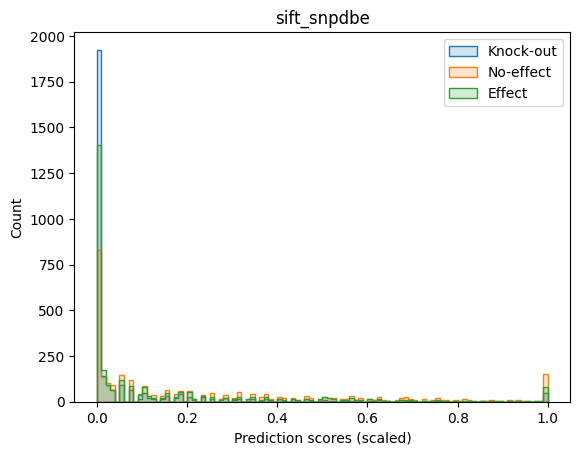

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(result_df, out_dir, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    if n_samples is not None:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"{out_dir}{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

# df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
# out_dir="models/aa_common/pred_scores_distribution_plots_pmd_human_analysis/"
# n_samples=None
# is_dbnsfp_ok = True

df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
out_dir="models/aa_common/pred_scores_distribution_plots_pmd_nonhuman_analysis/"
n_samples=3000
is_dbnsfp_ok = False

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "sift_snpdbe"
    if model_root=="dbnsfp" and ~is_dbnsfp_ok: continue
    
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        df[model_pred_col] = [random.uniform(0,1) for i in range(df.shape[0])]

    df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df = df[~pd.isna(df[model_pred_col])]  # taking df for only non-NAN values
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df, out_dir, n_samples)
    break



	AUC-PR: 0.361
(25873,)
	Best F1-Score: 0.655 at threshold: 0.000
(25868,)
[0.48721607 0.4871963  0.48717652 ... 0.14285714 0.16666667 1.        ]
[1.00000000e+00 9.99920849e-01 9.99841697e-01 ... 7.91514960e-05
 7.91514960e-05 0.00000000e+00]


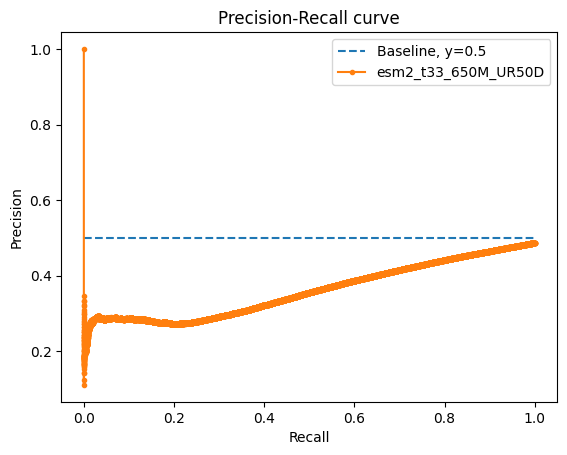

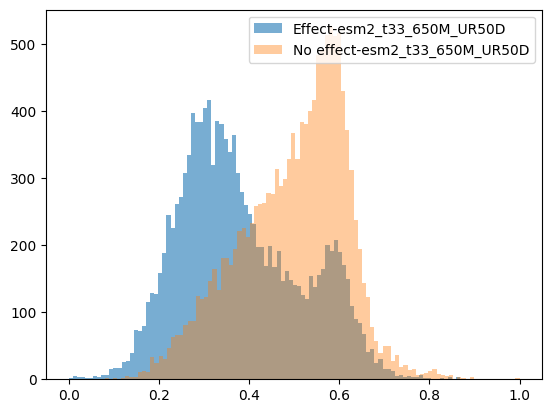

In [7]:

    

model_name = "esm2_t33_650M_UR50D"
model_pred_col = model_name + "_pred"

result_df.loc[result_df["functional_effect"]=="Effect", "class_numeric"] = 1
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 0

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
print(thresholds.shape)
print(precisions, recalls, sep="\n")

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


effect = result_df[result_df["functional_effect"]=="Effect"]
no_effect = result_df[result_df["functional_effect"]=="No effect"]

bins = 100 # 20, 100, 500
plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Effect-{model_name}")
plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No effect-{model_name}")

plt.legend()
plt.show()